In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cgm-dataset/data_2024-12-06_0003-00.csv
/kaggle/input/cgm-dataset/data_2024-12-05_0000-00.csv
/kaggle/input/cgm-dataset/data_2024-12-09_0002-00.csv
/kaggle/input/cgm-dataset/data_2024-11-29_12-45-00.csv
/kaggle/input/cgm-dataset/data_2024-12-03_1320-00.csv
/kaggle/input/cgm-dataset/data_2024-11-27_04-55-00.csv
/kaggle/input/cgm-dataset/data_2024-09-02_13-06-00.csv
/kaggle/input/cgm-dataset/data_2024-12-07_0000-00.csv
/kaggle/input/cgm-dataset/data_2024-12-02_0003-00.csv
/kaggle/input/cgm-dataset/Non Invasive Glucose Tracking Data.csv
/kaggle/input/cgm-dataset/data_2024-12-08_2142-00.csv
/kaggle/input/cgm-dataset/data_2024-09-04_14-10-00.csv
/kaggle/input/cgm-dataset/data_2024-12-04_0000-00.csv
/kaggle/input/cgm-dataset/data_2024-12-01_0413-00.csv


# Data Integration and Cleaning

Importing Libraries and setting environment 

In [2]:
import pandas as pd       # For data manipulation
import numpy as np        # For numerical computations
import glob               # For file handling
import os                 # For 
import matplotlib.pyplot as plt   # For plotting
import seaborn as sns     # For advanced plotting
from sklearn.model_selection import train_test_split  # For splitting data
from sklearn.ensemble import RandomForestRegressor    # For modeling
from sklearn.metrics import mean_absolute_error, r2_score  # For evaluation
from scipy import stats #Statistical Summary 
from sklearn.decomposition import PCA #For component Analysis
import torch #For Pytorch 
from scipy.signal import find_peaks # To plot peaks 

# Machine Learning libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

# For ANN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore') #turning of warnings 

# Check GPU availability and specs
!nvidia-smi

# Also check CUDA availability for deep learning frameworks
import torch
print("\nPyTorch CUDA Status:")
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Device:", torch.cuda.get_device_name(0))
    print("Number of GPUs:", torch.cuda.device_count())

# Check TensorFlow GPU access
import tensorflow as tf
print("\nTensorFlow GPU Status:")
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("TensorFlow Version:", tf.__version__)


Fri Dec 27 15:46:26 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Function to decode the timestamp encoded in data

In [3]:
def extract_start_time(filename):
    """
    Extracts the start datetime from the filename.
    Supports two formats:
    1. data_YYYY-MM-DD_HHMM-SS.csv
    2. data_YYYY-MM-DD_HH-MM-SS.csv
    """
    # Extract the base name of the file
    basename = os.path.basename(filename)  # e.g., 'data_2024-12-04_1330-00.csv' or 'data_2024-09-04_14-10-00.csv'
    # Remove the extension
    name_part = os.path.splitext(basename)[0]  # e.g., 'data_2024-12-04_1330-00' or 'data_2024-09-04_14-10-00'
    # Split the parts
    parts = name_part.split('_')  # ['data', '2024-12-04', '1330-00'] or ['data', '2024-09-04', '14-10-00']
    
    if len(parts) >= 3:
        date_str = parts[1]  # '2024-12-04' or '2024-09-04'
        time_str = parts[2]  # '1330-00' or '14-10-00'
        
        # Determine the format based on the number of dashes
        if time_str.count('-') == 2:
            # Format 2: 'HH-MM-SS'
            time_corrected = time_str.replace('-', ':')  # '14:10:00'
        elif time_str.count('-') == 1 and len(time_str.split('-')[0]) == 4:
            # Format 1: 'HHMM-SS'
            hhmm, ss = time_str.split('-')  # '1330', '00'
            hh = hhmm[:2]  # '13'
            mm = hhmm[2:]  # '30'
            time_corrected = f"{hh}:{mm}:{ss}"  # '13:30:00'
        else:
            # Unrecognized format
            raise ValueError(f"Filename '{filename}' has an unrecognized time format: '{time_str}'")
        
        # Combine date and time
        datetime_str = f"{date_str} {time_corrected}"  # '2024-12-04 13:30:00' or '2024-09-04 14:10:00'
        
        # Convert to datetime object
        try:
            start_time = pd.to_datetime(datetime_str, format='%Y-%m-%d %H:%M:%S')
        except ValueError as ve:
            raise ValueError(f"Error parsing datetime from filename '{filename}': {ve}")
        
        return start_time
    else:
        raise ValueError(f"Filename '{filename}' does not match the expected format.")

Loading and combining data and adding the actual timestamp column 

In [4]:
def load_and_process_files(directory):
    """
    Loads and processes all CSV files in the specified directory.
    """
    csv_files = glob.glob(os.path.join(directory, 'data_*.csv'))
    
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in directory '{directory}'")
    
    data_list = []
    failed_files = []  # Track failed files
    
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            
            # Validate required columns
            required_columns = ['Timestamp'] + [f'Channel {i}' for i in range(1, 19)]
            missing_columns = [col for col in required_columns if col not in df.columns]
            if missing_columns:
                raise ValueError(f"Missing columns: {missing_columns}")
            
            start_time = extract_start_time(file)
            
            # Standardize timestamp processing
            time_unit = 'ms' if df['Timestamp'].mean() > 1000 else 's'
            df['Timedelta'] = pd.to_timedelta(df['Timestamp'], unit=time_unit)
            df['ActualTimestamp'] = start_time + df['Timedelta']
            
            data_list.append(df)
            print(f"Successfully processed file: {file}")
        except Exception as e:
            failed_files.append((file, str(e)))
            print(f"Error processing file '{file}': {e}")
            continue
    
    if not data_list:
        raise ValueError("No data was loaded. Please check the CSV files and their formats.")
    
    # Report failed files
    if failed_files:
        print("\nFailed files summary:")
        for file, error in failed_files:
            print(f"- {os.path.basename(file)}: {error}")
    
    data = pd.concat(data_list, ignore_index=True)
    return data

Summary and execution 

In [5]:
# Define the directory containing your data files
data_directory = '/kaggle/input/cgm-dataset'

# Load and process data
try:
    data = load_and_process_files(data_directory)
    print("Data loaded and processed successfully.")
except Exception as e:
    print(f"Failed to load and process data: {e}")

# Set 'ActualTimestamp' as the datetime index (optional)
if 'ActualTimestamp' in data.columns:
    data.set_index('ActualTimestamp', inplace=True)
    print("'ActualTimestamp' set as the datetime index.")
else:
    print("'ActualTimestamp' column not found. Skipping setting the index.")

# Display the first few rows of the processed data
print(data.head())

Successfully processed file: /kaggle/input/cgm-dataset/data_2024-12-06_0003-00.csv
Successfully processed file: /kaggle/input/cgm-dataset/data_2024-12-05_0000-00.csv
Successfully processed file: /kaggle/input/cgm-dataset/data_2024-12-09_0002-00.csv
Successfully processed file: /kaggle/input/cgm-dataset/data_2024-11-29_12-45-00.csv
Successfully processed file: /kaggle/input/cgm-dataset/data_2024-12-03_1320-00.csv
Successfully processed file: /kaggle/input/cgm-dataset/data_2024-11-27_04-55-00.csv
Successfully processed file: /kaggle/input/cgm-dataset/data_2024-09-02_13-06-00.csv
Successfully processed file: /kaggle/input/cgm-dataset/data_2024-12-07_0000-00.csv
Successfully processed file: /kaggle/input/cgm-dataset/data_2024-12-02_0003-00.csv
Successfully processed file: /kaggle/input/cgm-dataset/data_2024-12-08_2142-00.csv
Successfully processed file: /kaggle/input/cgm-dataset/data_2024-09-04_14-10-00.csv
Successfully processed file: /kaggle/input/cgm-dataset/data_2024-12-04_0000-00.csv


We do the data cleaning and visualise it

=== Data Distribution Across Dates ===

Detailed Data Distribution:
Date         Total Records   Records with CGM Missing CGM %  
2024-09-02   75              75              0.00           %
2024-09-04   75              75              0.00           %
2024-11-27   102             102             0.00           %
2024-11-29   152             152             0.00           %
2024-11-30   25              25              0.00           %
2024-12-01   237             143             39.66          %
2024-12-02   50              13              74.00          %
2024-12-03   54              39              27.78          %
2024-12-04   286             227             20.63          %
2024-12-05   226             150             33.63          %
2024-12-06   177             42              76.27          %
2024-12-07   197             57              71.07          %
2024-12-08   70              70              0.00           %
2024-12-09   97              12              87.63          %


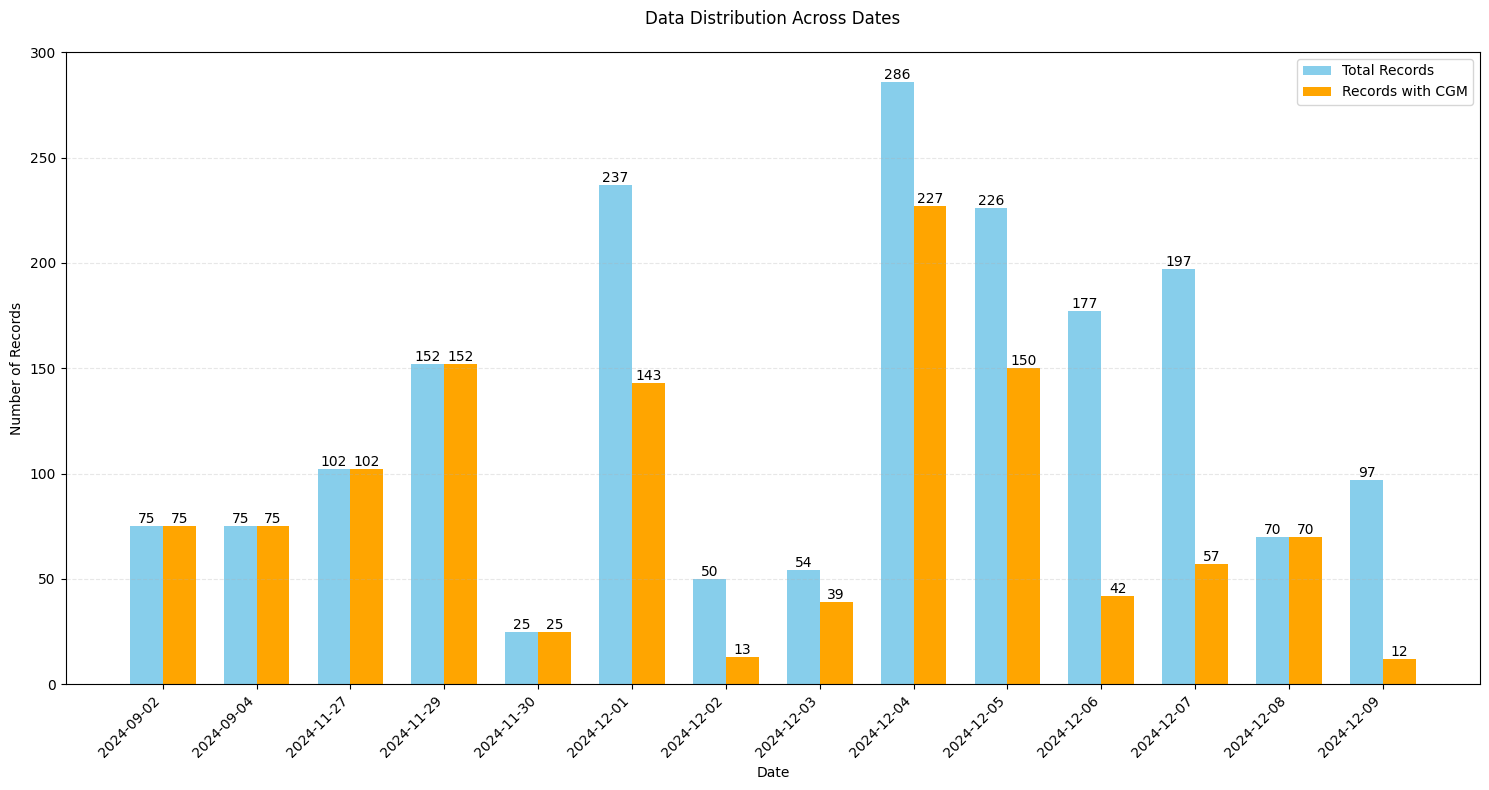


=== Summary Statistics ===
Total number of records: 1823
Total records with CGM: 1182
Overall missing CGM percentage: 35.16%
Date range: 2024-09-02 to 2024-12-09
Average records per day: 130.21


In [6]:
# Data distribution analysis with enhanced visualization
print("=== Data Distribution Across Dates ===")

# Convert ActualTimestamp to datetime if needed
if 'ActualTimestamp' in data.columns:
    data['Date'] = pd.to_datetime(data['ActualTimestamp']).dt.date
else:
    data['Date'] = data.index.date

# Get counts per date
daily_counts = data.groupby('Date').size()
daily_cgm_counts = data.groupby('Date')['CGM'].count()

# Calculate missing CGM percentage
missing_percentage = ((daily_counts - daily_cgm_counts) / daily_counts * 100).round(2)

# Print detailed statistics
print("\nDetailed Data Distribution:")
print("=" * 75)
print(f"{'Date':<12} {'Total Records':<15} {'Records with CGM':<15} {'Missing CGM %':<15}")
print("=" * 75)
for date in daily_counts.index:
    print(f"{date!s:<12} {daily_counts[date]:<15} {daily_cgm_counts[date]:<15} {missing_percentage[date]:<15.2f}%")

# Create enhanced visualization
plt.figure(figsize=(15, 8))
width = 0.35

x = np.arange(len(daily_counts))
bars1 = plt.bar(x - width/2, daily_counts.values, width, label='Total Records', color='skyblue')
bars2 = plt.bar(x + width/2, daily_cgm_counts.values, width, label='Records with CGM', color='orange')

# Customize plot
plt.title('Data Distribution Across Dates', fontsize=12, pad=20)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Number of Records', fontsize=10)
plt.xticks(x, [date.strftime('%Y-%m-%d') for date in daily_counts.index], rotation=45, ha='right')
plt.legend()

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

add_value_labels(bars1)
add_value_labels(bars2)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.3)

# Adjust layout
plt.tight_layout()

plt.show()

# Print summary statistics
print("\n=== Summary Statistics ===")
print(f"Total number of records: {len(data)}")
print(f"Total records with CGM: {data['CGM'].count()}")
print(f"Overall missing CGM percentage: {(1 - data['CGM'].count()/len(data))*100:.2f}%")
print(f"Date range: {min(daily_counts.index)} to {max(daily_counts.index)}")
print(f"Average records per day: {len(data)/len(daily_counts):.2f}")

Analysing CGM data 

=== CGM Analysis ===


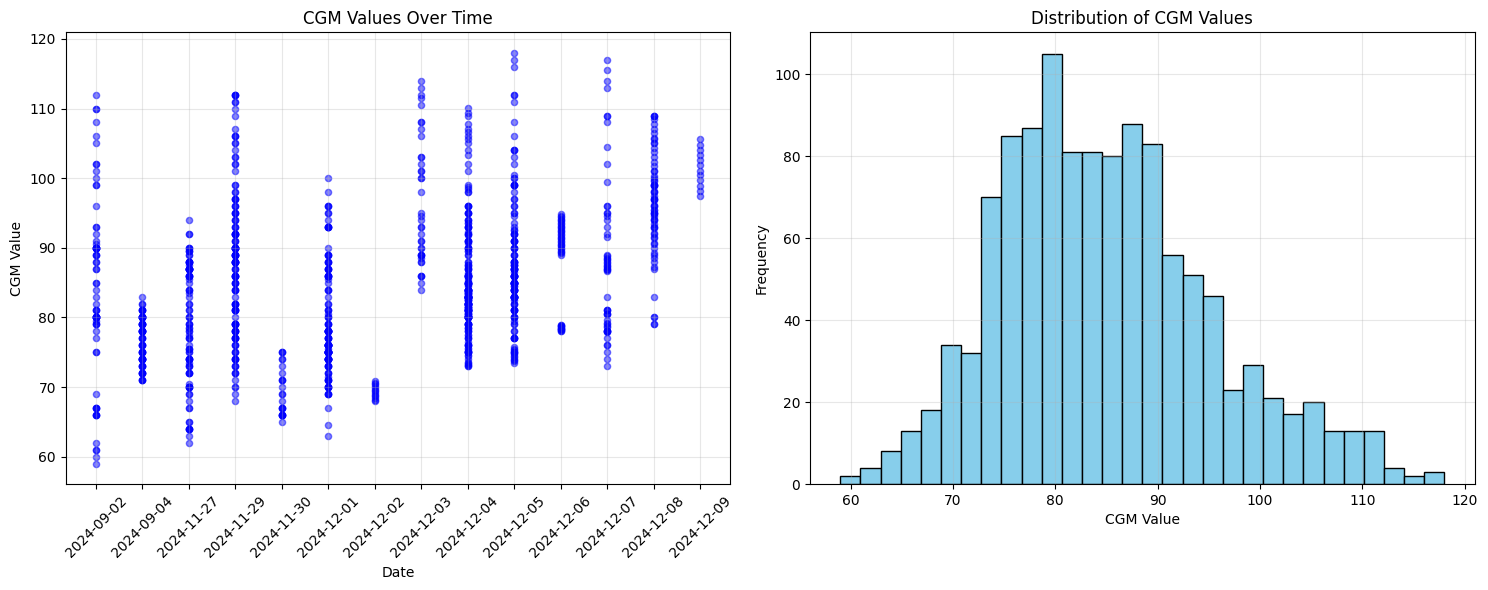


Daily CGM Statistics (Days with Data):
            Count    Mean    Std   Min    Max
Date                                         
2024-09-02     75   84.05  12.82  59.0  112.0
2024-09-04     75   76.68   3.25  71.0   83.0
2024-11-27    102   79.09   8.40  62.0   94.0
2024-11-29    152   87.75  10.50  68.0  112.0
2024-11-30     25   69.44   3.40  65.0   75.0
2024-12-01    143   79.09   7.62  63.0  100.0
2024-12-02     13   69.41   0.94  68.0   70.9
2024-12-03     39   96.64   9.09  84.0  114.0
2024-12-04    227   85.01   7.70  73.0  110.1
2024-12-05    150   87.59   9.24  73.5  118.0
2024-12-06     42   88.07   6.31  78.0   94.8
2024-12-07     57   88.57  11.55  73.0  117.0
2024-12-08     70   96.37   7.28  79.0  109.0
2024-12-09     12  101.50   2.67  97.4  105.6

=== CGM Summary Statistics ===
Overall CGM Range: 59.00 to 118.00
Mean CGM: 84.88
Median CGM: 84.00
Standard Deviation: 10.54

Potential anomalies detected: 18 (1.52%)


In [7]:
# Analyze CGM patterns (excluding days with no data)
print("=== CGM Analysis ===")

# Filter out days with no CGM data
valid_data = data.dropna(subset=['CGM'])

# Calculate daily statistics
daily_cgm_stats = valid_data.groupby('Date').agg({
    'CGM': ['count', 'mean', 'std', 'min', 'max']
}).round(2)

daily_cgm_stats.columns = ['Count', 'Mean', 'Std', 'Min', 'Max']

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. CGM Values Over Time with continuous x-axis
unique_dates = sorted(valid_data['Date'].unique())
date_to_index = {date: idx for idx, date in enumerate(unique_dates)}
x_values = [date_to_index[date] for date in valid_data['Date']]

ax1.scatter(x_values, valid_data['CGM'], alpha=0.5, color='blue', s=20)
ax1.set_xticks(range(len(unique_dates)))
ax1.set_xticklabels([date.strftime('%Y-%m-%d') for date in unique_dates], rotation=45)
ax1.set_title('CGM Values Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('CGM Value')
ax1.grid(True, alpha=0.3)

# 2. CGM Distribution
valid_data['CGM'].hist(bins=30, color='skyblue', edgecolor='black', ax=ax2)
ax2.set_title('Distribution of CGM Values')
ax2.set_xlabel('CGM Value')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("\nDaily CGM Statistics (Days with Data):")
print("=" * 80)
print(daily_cgm_stats)

print("\n=== CGM Summary Statistics ===")
print(f"Overall CGM Range: {valid_data['CGM'].min():.2f} to {valid_data['CGM'].max():.2f}")
print(f"Mean CGM: {valid_data['CGM'].mean():.2f}")
print(f"Median CGM: {valid_data['CGM'].median():.2f}")
print(f"Standard Deviation: {valid_data['CGM'].std():.2f}")

# Detect potential anomalies
q1 = valid_data['CGM'].quantile(0.25)
q3 = valid_data['CGM'].quantile(0.75)
iqr = q3 - q1
outliers = valid_data[(valid_data['CGM'] < (q1 - 1.5 * iqr)) | (valid_data['CGM'] > (q3 + 1.5 * iqr))]

print(f"\nPotential anomalies detected: {len(outliers)} ({(len(outliers)/len(valid_data)*100):.2f}%)")

=== NIR Channel Analysis ===

Channel Correlations with CGM:
            Correlation  Abs_Correlation
Channel 16    -0.080652         0.080652
Channel 10     0.071433         0.071433
Channel 2      0.067842         0.067842
Channel 18    -0.064599         0.064599
Channel 9      0.061008         0.061008
Channel 15    -0.060160         0.060160
Channel 5      0.054034         0.054034
Channel 1      0.048491         0.048491
Channel 4      0.046358         0.046358
Channel 6      0.045561         0.045561
Channel 3      0.044121         0.044121
Channel 12     0.042671         0.042671
Channel 14    -0.019370         0.019370
Channel 7      0.018195         0.018195
Channel 8      0.014960         0.014960
Channel 17    -0.012877         0.012877
Channel 13    -0.010314         0.010314
Channel 11    -0.007272         0.007272


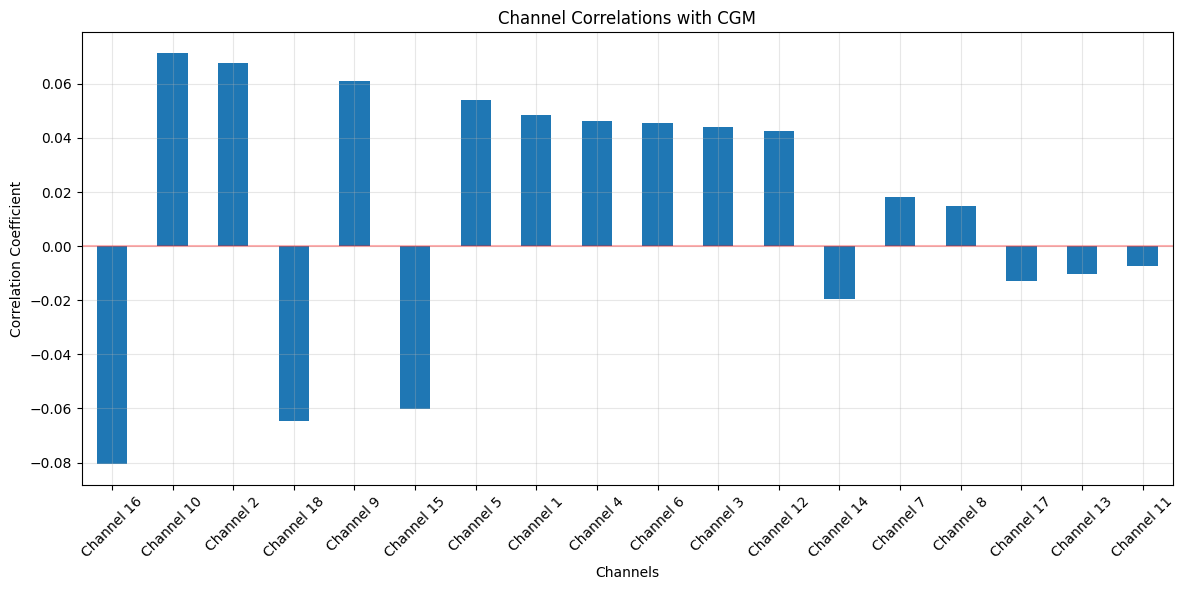

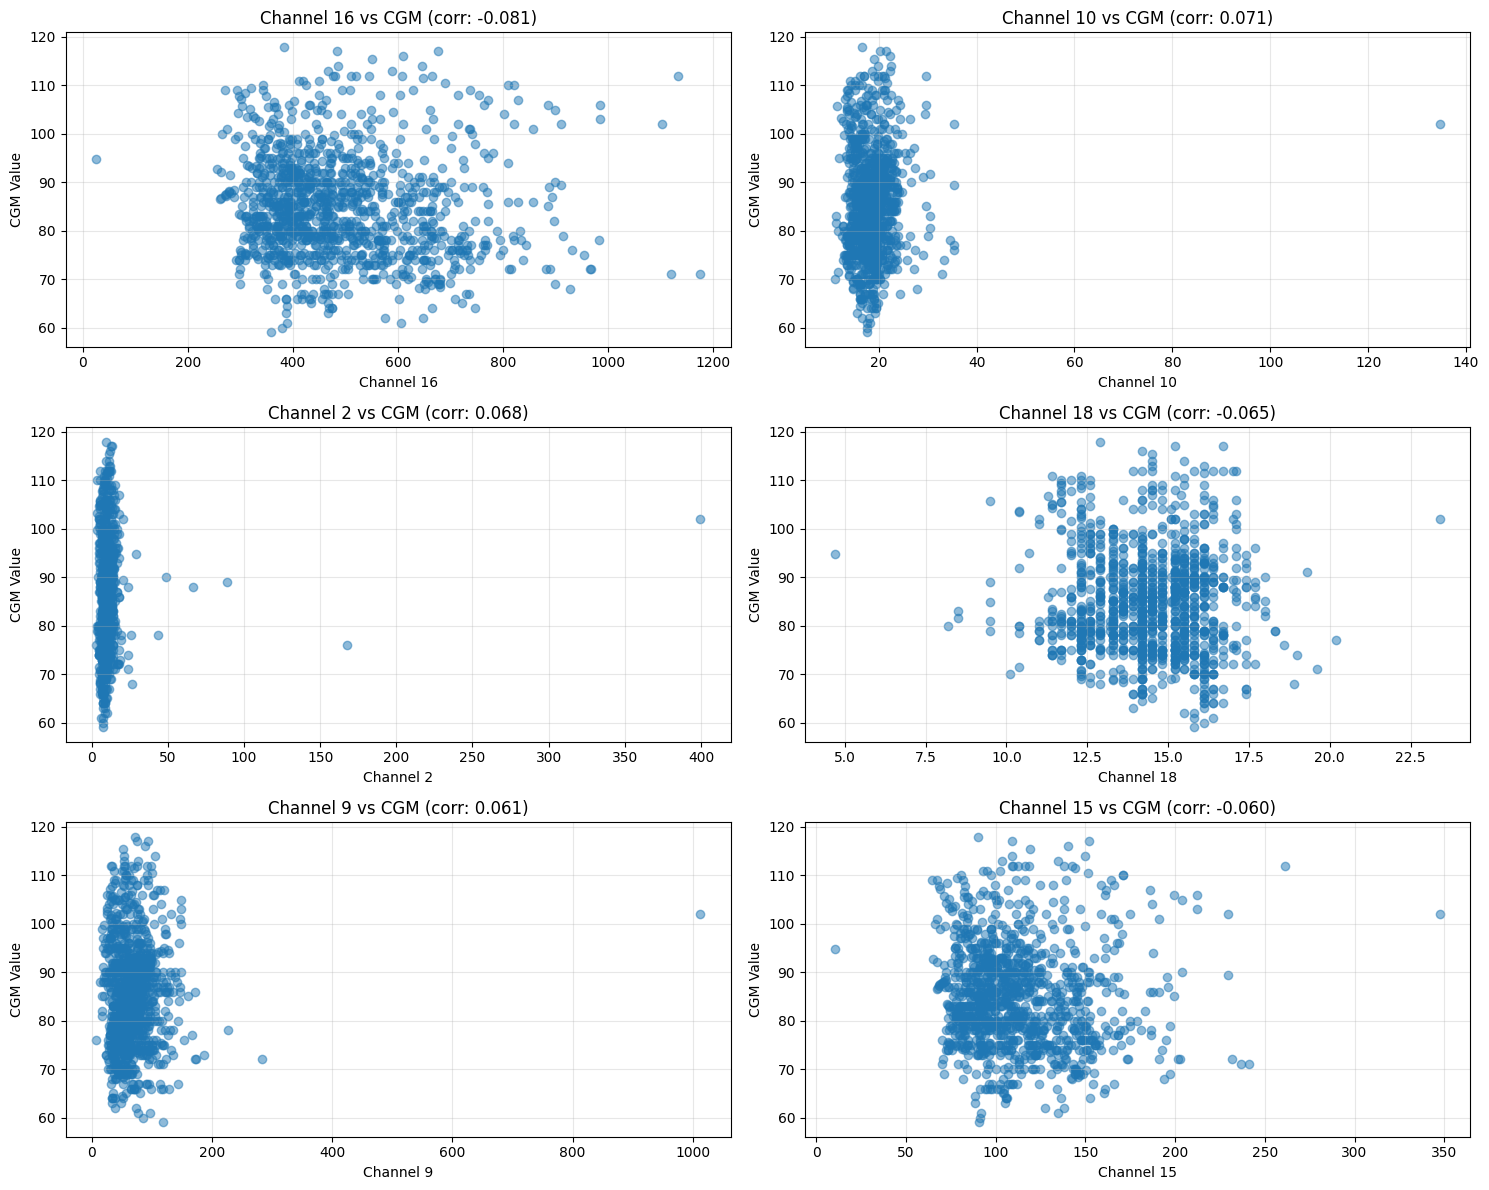


Channel Statistics:
         Channel 1    Channel 2    Channel 3    Channel 4    Channel 5  \
count  1182.000000  1182.000000  1182.000000  1182.000000  1182.000000   
mean      8.034433    10.085956    13.226311     4.314890    14.280795   
std      16.017382    12.978844    52.582763     9.701291    33.274867   
min       2.700000     2.800000     2.600000     0.800000     2.100000   
25%       5.800000     7.500000     8.000000     2.700000     8.500000   
50%       6.900000     9.300000     9.800000     3.300000    11.000000   
75%       8.400000    11.300000    11.600000     4.200000    15.600000   
max     423.400000   399.700000  1637.900000   294.600000  1016.500000   

         Channel 6    Channel 7    Channel 8    Channel 9   Channel 10  \
count  1182.000000  1182.000000  1182.000000  1182.000000  1182.000000   
mean      6.268105     6.561591     8.500085    66.344839    18.479865   
std      18.346456     1.992045     2.317048    39.065880     4.619799   
min       0.6000

In [8]:
# Analyze NIR channels in relation to CGM values
print("=== NIR Channel Analysis ===")

# Get channel columns
channel_cols = [f'Channel {i}' for i in range(1, 19)]

# Calculate correlations with CGM
correlations = pd.DataFrame()
correlations['Correlation'] = [valid_data['CGM'].corr(valid_data[col]) for col in channel_cols]
correlations.index = channel_cols

# Sort correlations by absolute value
correlations['Abs_Correlation'] = correlations['Correlation'].abs()
correlations = correlations.sort_values('Abs_Correlation', ascending=False)

print("\nChannel Correlations with CGM:")
print(correlations)

# Visualize correlations
plt.figure(figsize=(12, 6))
correlations['Correlation'].plot(kind='bar')
plt.title('Channel Correlations with CGM')
plt.xlabel('Channels')
plt.ylabel('Correlation Coefficient')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot top 6 channels vs CGM
top_channels = correlations.index[:6]
n_channels = len(top_channels)
n_cols = 2
n_rows = (n_channels + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for idx, channel in enumerate(top_channels):
    # Scatter plot
    axes[idx].scatter(valid_data[channel], valid_data['CGM'], alpha=0.5)
    axes[idx].set_title(f'{channel} vs CGM (corr: {correlations.loc[channel, "Correlation"]:.3f})')
    axes[idx].set_xlabel(channel)
    axes[idx].set_ylabel('CGM Value')
    axes[idx].grid(True, alpha=0.3)

# Remove empty subplots
for idx in range(len(top_channels), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Statistical summary of channels
print("\nChannel Statistics:")
print(valid_data[channel_cols].describe())


# Prepare data for modeling
print("\nTop Channels for Analysis:")
for channel in top_channels:
    corr = correlations.loc[channel, 'Correlation']
    print(f"{channel}: correlation = {corr:.3f}")

=== Channel Analysis with Filtered Data ===
Number of valid days: 7
Valid days: Index([2024-09-02, 2024-09-04, 2024-11-27, 2024-11-29, 2024-12-01, 2024-12-04,
       2024-12-05],
      dtype='object', name='Date')

Top 3 Negatively Correlated Channels:
            Correlation
Channel 16    -0.078201
Channel 15    -0.049608
Channel 18    -0.040459
Analyzing data for date: 2024-09-02
Number of records: 75
Analyzing data for date: 2024-09-04
Number of records: 75
Analyzing data for date: 2024-11-27
Number of records: 102
Analyzing data for date: 2024-11-29
Number of records: 152
Analyzing data for date: 2024-12-01
Number of records: 143
Analyzing data for date: 2024-12-04
Number of records: 227
Analyzing data for date: 2024-12-05
Number of records: 150
Days with valid patterns: 7
Days to plot: [datetime.date(2024, 9, 2), datetime.date(2024, 9, 4), datetime.date(2024, 11, 27), datetime.date(2024, 11, 29), datetime.date(2024, 12, 1), datetime.date(2024, 12, 4), datetime.date(2024, 12, 5)]


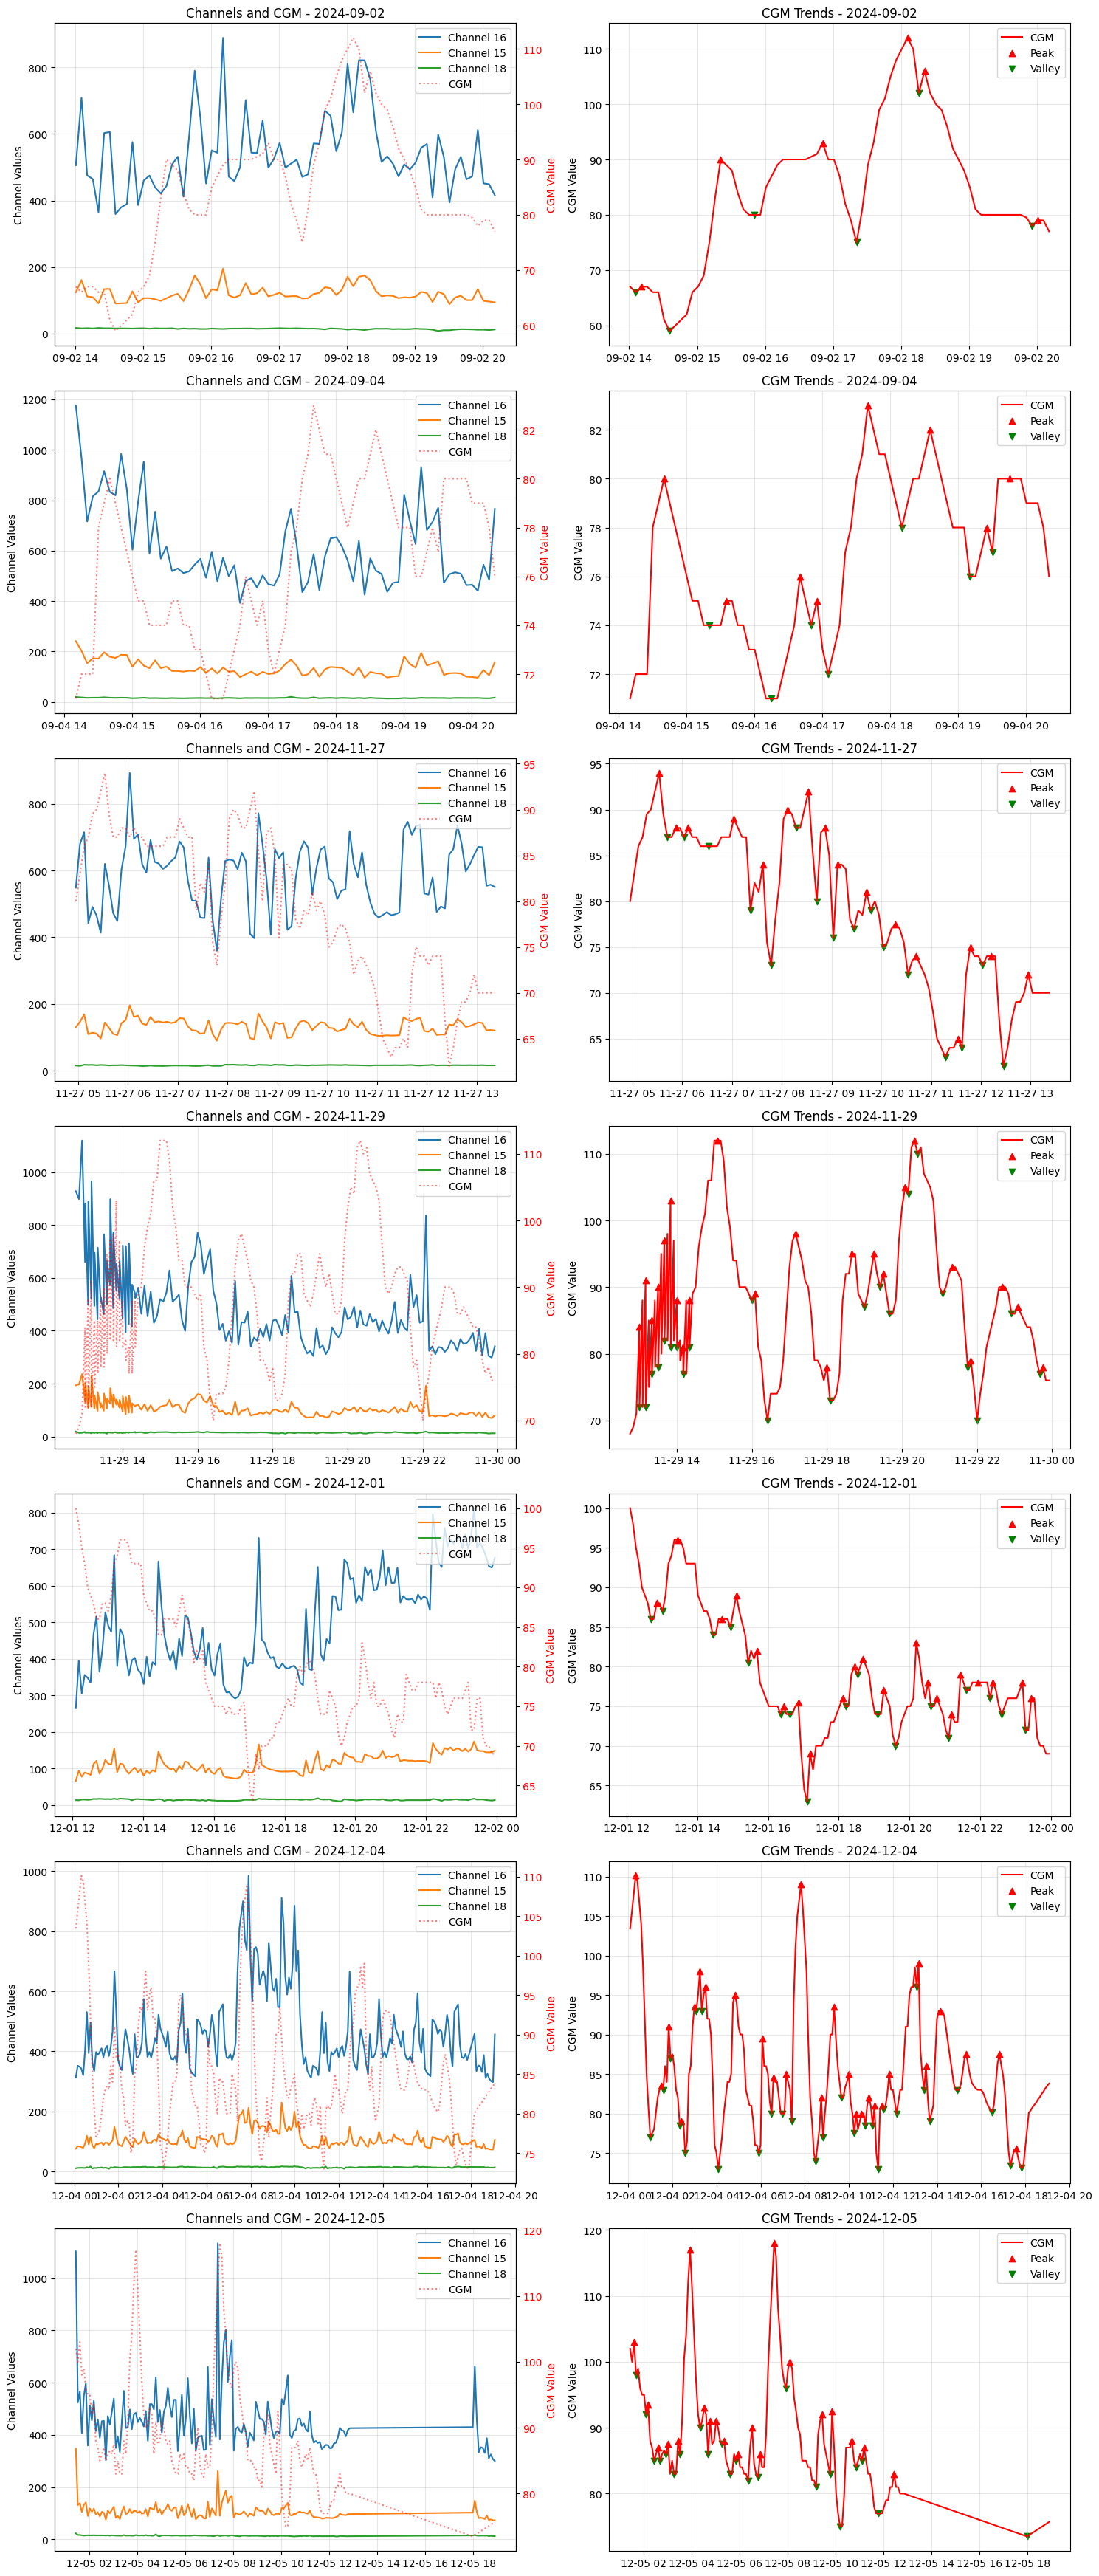

In [9]:
# Required imports at the top
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Enhanced analysis focusing on days with sufficient data
print("=== Channel Analysis with Filtered Data ===")

# First, get days with at least 75 records
day_counts = valid_data.groupby('Date').size()
valid_days = day_counts[day_counts >= 75].index

print("Number of valid days:", len(valid_days))
print("Valid days:", valid_days)

# Filter data for valid days
filtered_data = valid_data[valid_data['Date'].isin(valid_days)]

# Get top 3 negatively correlated channels
channel_cols = [f'Channel {i}' for i in range(1, 19)]
correlations = pd.DataFrame()
correlations['Correlation'] = [filtered_data['CGM'].corr(filtered_data[col]) for col in channel_cols]
correlations.index = channel_cols
correlations = correlations.sort_values('Correlation')

top_negative_channels = correlations.head(3).index.tolist()
print("\nTop 3 Negatively Correlated Channels:")
print(correlations.head(3))

def analyze_daily_patterns(day_data):
    """Analyze patterns for selected channels and CGM"""
    try:
        day_data = day_data.sort_index()
        
        print(f"Analyzing data for date: {day_data.index[0].date()}")
        print(f"Number of records: {len(day_data)}")
        
        # Find CGM peaks and valleys
        cgm_values = day_data['CGM'].values
        if len(cgm_values) < 3:
            print("Not enough data points for peak detection")
            return None
            
        cgm_peaks, _ = find_peaks(cgm_values, distance=3)
        cgm_valleys, _ = find_peaks(-cgm_values, distance=3)
        
        # Store peaks for each channel
        channel_peaks = {}
        for channel in top_negative_channels:
            channel_values = day_data[channel].values
            peaks, _ = find_peaks(-channel_values, distance=3)
            valleys, _ = find_peaks(channel_values, distance=3)
            channel_peaks[channel] = {'peaks': peaks, 'valleys': valleys}
        
        return {
            'data': day_data,
            'cgm_peaks': cgm_peaks,
            'cgm_valleys': cgm_valleys,
            'channel_peaks': channel_peaks
        }
    except Exception as e:
        print(f"Error analyzing data for {day_data.index[0].date()}: {str(e)}")
        return None

# Analyze filtered days
daily_patterns = {}
for date in valid_days:
    day_data = filtered_data[filtered_data['Date'] == date]
    if not day_data['CGM'].isnull().all():
        patterns = analyze_daily_patterns(day_data)
        if patterns:
            daily_patterns[date] = patterns

print("Days with valid patterns:", len(daily_patterns))
print("Days to plot:", list(daily_patterns.keys()))

# Visualization
days = sorted(daily_patterns.keys())
n_days = len(days)

if n_days == 0:
    print("No valid days found for plotting!")
    plt.figure(figsize=(10, 5))
    plt.text(0.5, 0.5, 'No valid data available for plotting', 
             horizontalalignment='center', verticalalignment='center')
    plt.axis('off')
else:
    n_cols = 2
    n_rows = n_days
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    
    # Ensure axes is 2D
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, day in enumerate(days):
        patterns = daily_patterns[day]
        day_data = patterns['data']
        
        # Left plot: Channels with CGM overlay
        ax1 = axes[idx, 0]
        
        # Plot each channel
        for channel in top_negative_channels:
            ax1.plot(day_data.index, day_data[channel], '-', label=channel)
        
        # Add CGM overlay
        ax1_twin = ax1.twinx()
        ax1_twin.plot(day_data.index, day_data['CGM'], 'r:', alpha=0.5, label='CGM')
        ax1_twin.set_ylabel('CGM Value', color='red')
        ax1_twin.tick_params(axis='y', labelcolor='red')
        
        ax1.set_title(f'Channels and CGM - {day}')
        ax1.set_ylabel('Channel Values')
        ax1.grid(True, alpha=0.3)
        
        # Combine legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax1_twin.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
        
        # Right plot: CGM with peaks and valleys
        ax2 = axes[idx, 1]
        ax2.plot(day_data.index, day_data['CGM'], 'r-', label='CGM')
        
        if len(patterns['cgm_peaks']) > 0:
            peak_times = day_data.index[patterns['cgm_peaks']]
            peak_values = day_data['CGM'].iloc[patterns['cgm_peaks']]
            ax2.scatter(peak_times, peak_values, color='red', 
                       marker='^', label='Peak')
        
        if len(patterns['cgm_valleys']) > 0:
            valley_times = day_data.index[patterns['cgm_valleys']]
            valley_values = day_data['CGM'].iloc[patterns['cgm_valleys']]
            ax2.scatter(valley_times, valley_values, color='green', 
                       marker='v', label='Valley')
        
        ax2.set_title(f'CGM Trends - {day}')
        ax2.set_ylabel('CGM Value')
        ax2.grid(True, alpha=0.3)
        ax2.legend()

    plt.tight_layout()
    plt.show()

In [10]:
# Required imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def calculate_peak_valley_ratio(signal, distance=3):
    """Calculate peak to valley ratio with better error handling"""
    try:
        # Normalize signal to avoid negative values
        signal_norm = signal - np.min(signal) + 1
        
        # Find peaks and valleys
        peaks, _ = find_peaks(signal_norm, distance=distance)
        valleys, _ = find_peaks(-signal_norm, distance=distance)
        
        if len(peaks) > 0 and len(valleys) > 0:
            peak_mean = np.mean(signal_norm[peaks])
            valley_mean = np.mean(signal_norm[valleys])
            return peak_mean / valley_mean
        else:
            # Return 1.0 if no peaks/valleys found (neutral ratio)
            return 1.0
    except Exception as e:
        print(f"Error in peak-valley calculation: {e}")
        return 1.0

def create_signal_features(data, channel_cols, window_sizes=[5, 10, 15]):
    """Create signal processing and lag features for glucose trend prediction"""
    features = data.copy()
    
    # 1. Signal Processing Features
    for channel in channel_cols:
        signal = features[channel].values
        
        # Rolling statistics
        for window in window_sizes:
            features[f'{channel}_roll_mean_{window}'] = features[channel].rolling(window=window).mean()
            features[f'{channel}_roll_std_{window}'] = features[channel].rolling(window=window).std()
            
        # Rate of change (first derivative)
        features[f'{channel}_diff'] = np.gradient(signal)
        
        # Acceleration (second derivative)
        features[f'{channel}_accel'] = np.gradient(np.gradient(signal))
        
        # Peak to Valley ratio - Using the new function
        features[f'{channel}_peak_valley_ratio'] = calculate_peak_valley_ratio(signal)

    # 2. CGM-specific features
    # Calculate glucose rate of change
    features['glucose_rate'] = features['CGM'].diff() / features.index.to_series().diff().dt.total_seconds()
    
    # Rolling glucose statistics
    for window in window_sizes:
        features[f'glucose_roll_mean_{window}'] = features['CGM'].rolling(window=window).mean()
        features[f'glucose_roll_std_{window}'] = features['CGM'].rolling(window=window).std()
    
    # 3. Trend indicators
    # Calculate trend based on rolling averages
    features['glucose_trend'] = np.where(
        features['glucose_rate'] > 0.1, 'rising',
        np.where(features['glucose_rate'] < -0.1, 'falling', 'stable')
    )
    
    # 4. Lag features
    for lag in [1, 2, 3, 5]:
        features[f'CGM_lag_{lag}'] = features['CGM'].shift(lag)
        for channel in channel_cols:
            features[f'{channel}_lag_{lag}'] = features[channel].shift(lag)
    
    # 5. Range-based features
    for window in window_sizes:
        roll = features['CGM'].rolling(window=window)
        features[f'glucose_range_{window}'] = roll.max() - roll.min()
        features[f'glucose_range_ratio_{window}'] = (roll.max() - roll.min()) / (roll.mean() + 1e-6)
    
    return features



Feature Overview:
['Act Timestamp', 'Packet Number', 'Timestamp', 'Channel 1', 'Channel 2', 'Channel 3', 'Channel 4', 'Channel 5', 'Channel 6', 'Channel 7', 'Channel 8', 'Channel 9', 'Channel 10', 'Channel 11', 'Channel 12', 'Channel 13', 'Channel 14', 'Channel 15', 'Channel 16', 'Channel 17', 'Channel 18', 'CGM', 'Timedelta', 'Date', 'Channel 16_roll_mean_5', 'Channel 16_roll_std_5', 'Channel 16_roll_mean_10', 'Channel 16_roll_std_10', 'Channel 16_roll_mean_15', 'Channel 16_roll_std_15', 'Channel 16_diff', 'Channel 16_accel', 'Channel 16_peak_valley_ratio', 'Channel 15_roll_mean_5', 'Channel 15_roll_std_5', 'Channel 15_roll_mean_10', 'Channel 15_roll_std_10', 'Channel 15_roll_mean_15', 'Channel 15_roll_std_15', 'Channel 15_diff', 'Channel 15_accel', 'Channel 15_peak_valley_ratio', 'Channel 18_roll_mean_5', 'Channel 18_roll_std_5', 'Channel 18_roll_mean_10', 'Channel 18_roll_std_10', 'Channel 18_roll_mean_15', 'Channel 18_roll_std_15', 'Channel 18_diff', 'Channel 18_accel', 'Channel 1

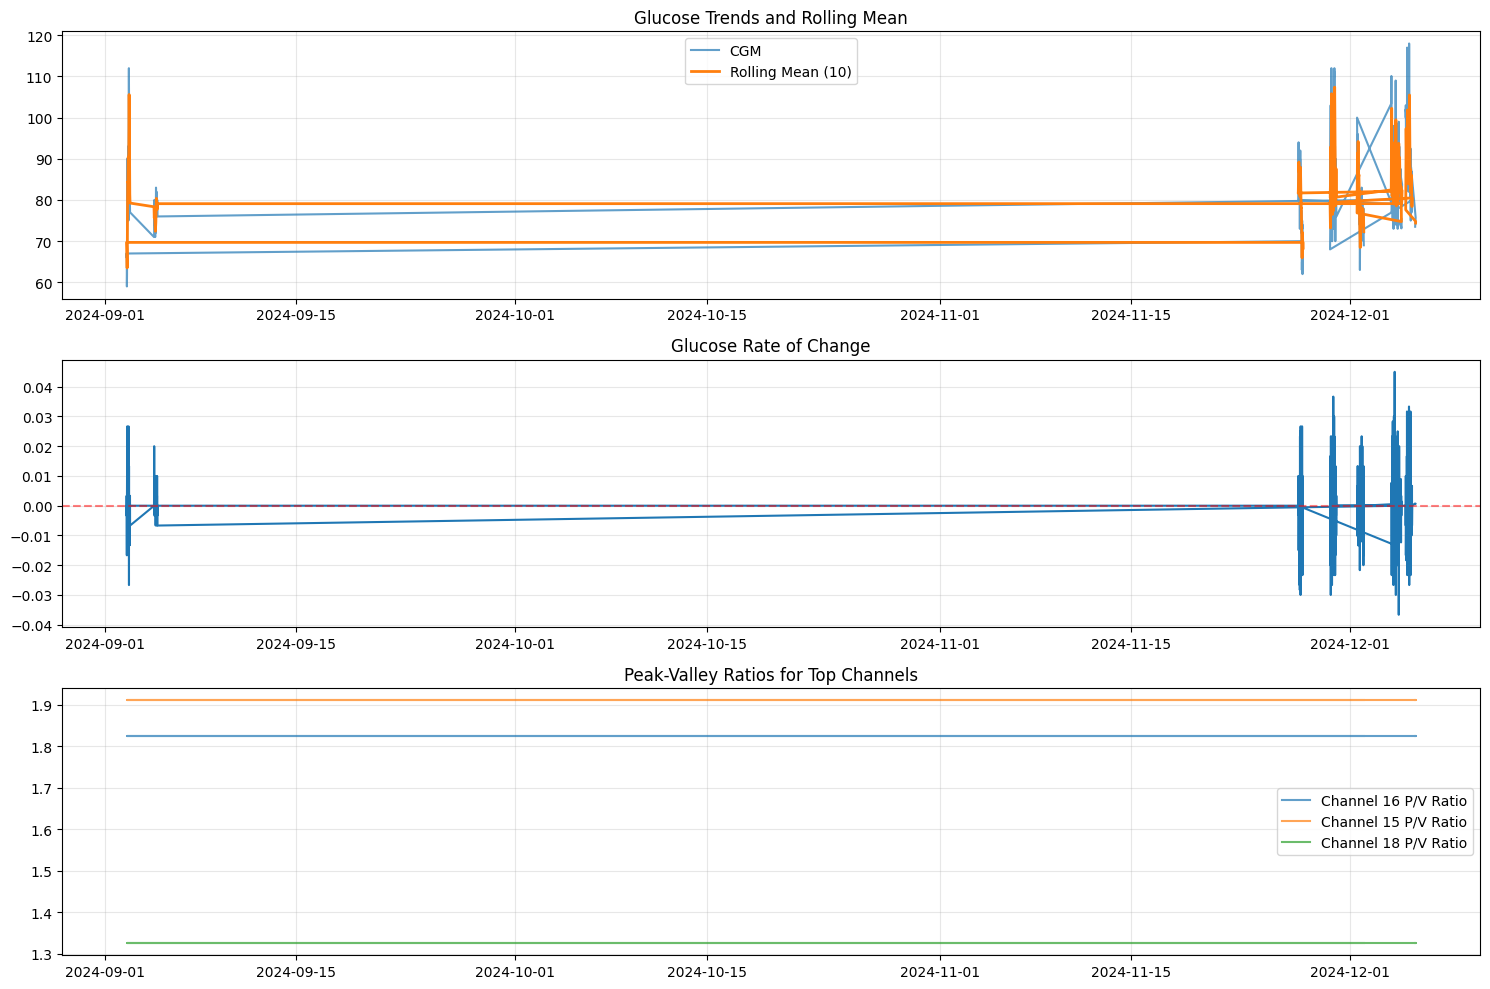


Feature Importance Summary:

Top 10 Most Important Features:
glucose_rate            1.000000
CGM_lag_3               0.303612
CGM_lag_5               0.285168
CGM_lag_2               0.260206
glucose_roll_mean_10    0.223329
glucose_roll_mean_5     0.195581
CGM_lag_1               0.172667
glucose_roll_mean_15    0.162637
CGM                     0.127343
glucose_roll_std_15     0.095347
Name: glucose_rate, dtype: float64


In [11]:
# Create features for the filtered data
feature_data = create_signal_features(
    filtered_data, 
    channel_cols=top_negative_channels,
    window_sizes=[5, 10, 15]
)

# Print sample of created features
print("\nFeature Overview:")
print(feature_data.columns.tolist())

# Basic feature analysis
print("\nFeature Statistics:")
print(feature_data.describe())

# Analyze correlation with glucose trend (only numeric columns)
print("\nTop Feature Correlations with Glucose Rate:")
# Filter numeric columns only
numeric_columns = feature_data.select_dtypes(include=['float64', 'int64']).columns
correlations = feature_data[numeric_columns].corr()['glucose_rate'].sort_values(ascending=False)
print(correlations.head(10))
print("\nBottom Feature Correlations with Glucose Rate:")
print(correlations.tail(10))

# Visualize key features
plt.figure(figsize=(15, 10))

# Plot 1: Glucose Trends
plt.subplot(3, 1, 1)
plt.title('Glucose Trends and Rolling Mean')
plt.plot(feature_data.index, feature_data['CGM'], label='CGM', alpha=0.7)
plt.plot(feature_data.index, feature_data['glucose_roll_mean_10'], 
         label='Rolling Mean (10)', linewidth=2)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Glucose Rate of Change
plt.subplot(3, 1, 2)
plt.title('Glucose Rate of Change')
plt.plot(feature_data.index, feature_data['glucose_rate'])
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

# Plot 3: Peak-Valley Ratios
plt.subplot(3, 1, 3)
plt.title('Peak-Valley Ratios for Top Channels')
for channel in top_negative_channels:
    plt.plot(feature_data.index, 
             feature_data[f'{channel}_peak_valley_ratio'], 
             label=f'{channel} P/V Ratio',
             alpha=0.7)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print feature importance summary
print("\nFeature Importance Summary:")
important_features = abs(correlations).sort_values(ascending=False)
print("\nTop 10 Most Important Features:")
print(important_features.head(10))

We should focus on as per our findings:
1. Recent history (last 3-5 readings)
2. Short-term variability metrics
3. Rolling statistics, especially for Channel 16
4. Glucose range ratios for trend detection

In [12]:
# Import required libraries
import cupy as cp  # For GPU acceleration
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import time

class GlucosePredictorGPU:
    def __init__(self, window_size=5, prediction_horizon=3):
        self.window_size = window_size
        self.prediction_horizon = prediction_horizon
        self.models = {
            'Linear Regression': LinearRegression(),
            'Polynomial Regression': Pipeline([
                ('poly', PolynomialFeatures(degree=2)),
                ('linear', LinearRegression())
            ]),
            'Ridge': Ridge(alpha=1.0),
            'Lasso': Lasso(alpha=1.0),
            'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100),
            'SVR': SVR(kernel='rbf'),
            'PCA + Linear Regression': Pipeline([
                ('pca', PCA(n_components=0.95)),
                ('linear', LinearRegression())
            ])
        }
        self.scalers = {}
        self.trained_models = {}
        
    def create_window_features(self, data):
        """Create features using GPU acceleration"""
        features = []
        targets = []
        
        # Move data to GPU
        channel_cols = [f'Channel {i}' for i in range(1, 19)]
        gpu_data = {col: cp.array(data[col].values) for col in channel_cols + ['CGM']}
        
        for i in range(self.window_size, len(data) - self.prediction_horizon):
            window_data = []
            for channel in channel_cols:
                channel_window = gpu_data[channel][i-self.window_size:i]
                window_data.extend(cp.asnumpy(channel_window))
                # Calculate statistics on GPU
                window_data.extend([
                    float(cp.mean(channel_window)),
                    float(cp.std(channel_window)),
                    float(cp.min(channel_window)),
                    float(cp.max(channel_window)),
                    float(cp.median(channel_window)),
                    float(cp.ptp(channel_window))
                ])
            
            cgm_window = gpu_data['CGM'][i-self.window_size:i]
            window_data.extend([
                float(gpu_data['CGM'][i]),
                float(cp.mean(cgm_window)),
                float(cp.std(cgm_window)),
                float(cp.gradient(cgm_window)[-1])
            ])
            
            features.append(window_data)
            targets.append(float(gpu_data['CGM'][i + self.prediction_horizon]))
        
        return np.array(features), np.array(targets)

    def calculate_accuracy(self, y_true, y_pred, tolerance=10):
        """Calculate prediction accuracy within tolerance"""
        within_tolerance = np.abs(y_true - y_pred) <= tolerance
        return np.mean(within_tolerance) * 100

    def train_and_evaluate(self, data):
        """Train all models and evaluate their performance"""
        print(f"Creating features with window size {self.window_size} and horizon {self.prediction_horizon}")
        start_time = time.time()
        X, y = self.create_window_features(data)
        feature_time = time.time() - start_time
        print(f"Feature creation time: {feature_time:.2f} seconds")
        
        # Split data chronologically
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        results = {}
        for name, model in self.models.items():
            print(f"\nTraining {name}...")
            try:
                # Train model
                start_time = time.time()
                model.fit(X_train_scaled, y_train)
                training_time = time.time() - start_time
                
                # Make predictions
                start_time = time.time()
                y_pred = model.predict(X_test_scaled)
                prediction_time = time.time() - start_time
                
                # Calculate metrics
                mse = mean_squared_error(y_test, y_pred)
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                accuracy = self.calculate_accuracy(y_test, y_pred)
                
                results[name] = {
                    'mse': mse,
                    'mae': mae,
                    'r2': r2,
                    'accuracy': accuracy,
                    'predictions': y_pred,
                    'training_time': training_time,
                    'prediction_time': prediction_time
                }
                
                self.trained_models[name] = model
                self.scalers[name] = scaler
                
                print(f"{name} Performance:")
                print(f"MSE: {mse:.2f}")
                print(f"MAE: {mae:.2f}")
                print(f"R²: {r2:.2f}")
                print(f"Accuracy (±10 mg/dL): {accuracy:.2f}%")
                print(f"Training Time: {training_time:.2f} seconds")
                print(f"Prediction Time: {prediction_time:.2f} seconds")
                
            except Exception as e:
                print(f"Error training {name}: {str(e)}")
        
        # Visualize results
        self.plot_results(y_test, results)
        return results

    def plot_results(self, y_test, results):
        """Plot comparison of model predictions with fixed glucose range"""
        # Time series plot
        plt.figure(figsize=(15, 6))
        
        # Plot actual values
        plt.plot(y_test, label='Actual', alpha=0.7, color='black', linewidth=2)
        
        # Plot predictions for each model
        for name, result in results.items():
            plt.plot(result['predictions'], label=name, alpha=0.5)
        
        # Set y-axis limits for glucose range
        plt.ylim(0, 175)  # Set fixed range for glucose values
        
        # Add horizontal lines for glucose ranges
        plt.axhspan(0, 70, color='red', alpha=0.1, label='Hypoglycemia')
        plt.axhspan(70, 140, color='green', alpha=0.1, label='Normal')
        plt.axhspan(140, 175, color='yellow', alpha=0.1, label='Hyperglycemia')
        
        plt.title(f'Glucose Predictions (Horizon: {self.prediction_horizon} points)', fontsize=12)
        plt.xlabel('Time Points', fontsize=10)
        plt.ylabel('Glucose Level (mg/dL)', fontsize=10)
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    
       
    
        # Create subplots for metrics
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        


=== Training models with window size 3 and horizon 3 ===
Creating features with window size 3 and horizon 3
Feature creation time: 16.76 seconds

Training Linear Regression...
Linear Regression Performance:
MSE: 31.66
MAE: 4.07
R²: 0.37
Accuracy (±10 mg/dL): 92.93%
Training Time: 0.03 seconds
Prediction Time: 0.00 seconds

Training Polynomial Regression...
Polynomial Regression Performance:
MSE: 254.35
MAE: 12.12
R²: -4.07
Accuracy (±10 mg/dL): 50.54%
Training Time: 1.49 seconds
Prediction Time: 0.02 seconds

Training Ridge...
Ridge Performance:
MSE: 29.18
MAE: 3.86
R²: 0.42
Accuracy (±10 mg/dL): 94.02%
Training Time: 0.01 seconds
Prediction Time: 0.00 seconds

Training Lasso...
Lasso Performance:
MSE: 25.40
MAE: 3.79
R²: 0.49
Accuracy (±10 mg/dL): 97.28%
Training Time: 0.00 seconds
Prediction Time: 0.00 seconds

Training Random Forest...
Random Forest Performance:
MSE: 46.22
MAE: 4.38
R²: 0.08
Accuracy (±10 mg/dL): 92.39%
Training Time: 4.49 seconds
Prediction Time: 0.00 seconds

Tra

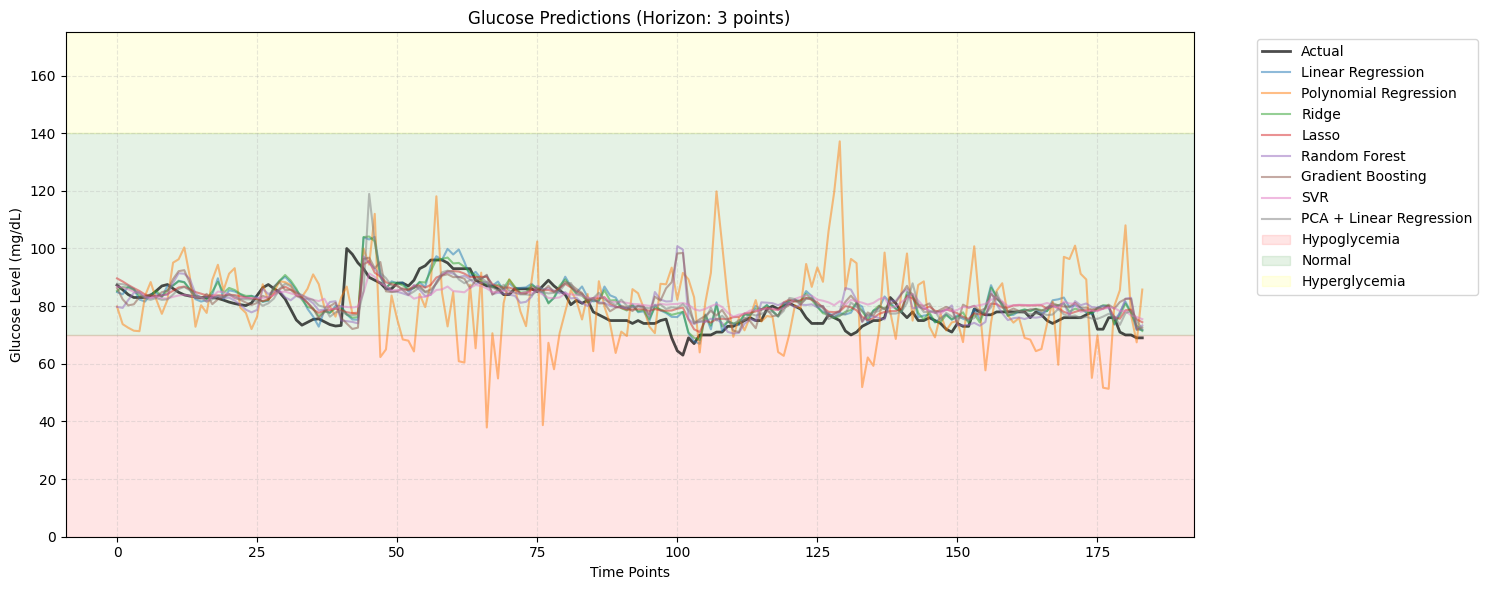


=== Training models with window size 3 and horizon 5 ===
Creating features with window size 3 and horizon 5
Feature creation time: 13.75 seconds

Training Linear Regression...
Linear Regression Performance:
MSE: 45.44
MAE: 5.45
R²: 0.09
Accuracy (±10 mg/dL): 84.78%
Training Time: 0.01 seconds
Prediction Time: 0.00 seconds

Training Polynomial Regression...
Polynomial Regression Performance:
MSE: 498.66
MAE: 15.44
R²: -8.94
Accuracy (±10 mg/dL): 47.28%
Training Time: 1.44 seconds
Prediction Time: 0.02 seconds

Training Ridge...
Ridge Performance:
MSE: 41.67
MAE: 5.18
R²: 0.17
Accuracy (±10 mg/dL): 88.59%
Training Time: 0.01 seconds
Prediction Time: 0.00 seconds

Training Lasso...
Lasso Performance:
MSE: 41.49
MAE: 5.22
R²: 0.17
Accuracy (±10 mg/dL): 90.22%
Training Time: 0.00 seconds
Prediction Time: 0.01 seconds

Training Random Forest...
Random Forest Performance:
MSE: 61.94
MAE: 5.87
R²: -0.23
Accuracy (±10 mg/dL): 85.33%
Training Time: 4.56 seconds
Prediction Time: 0.01 seconds

Tr

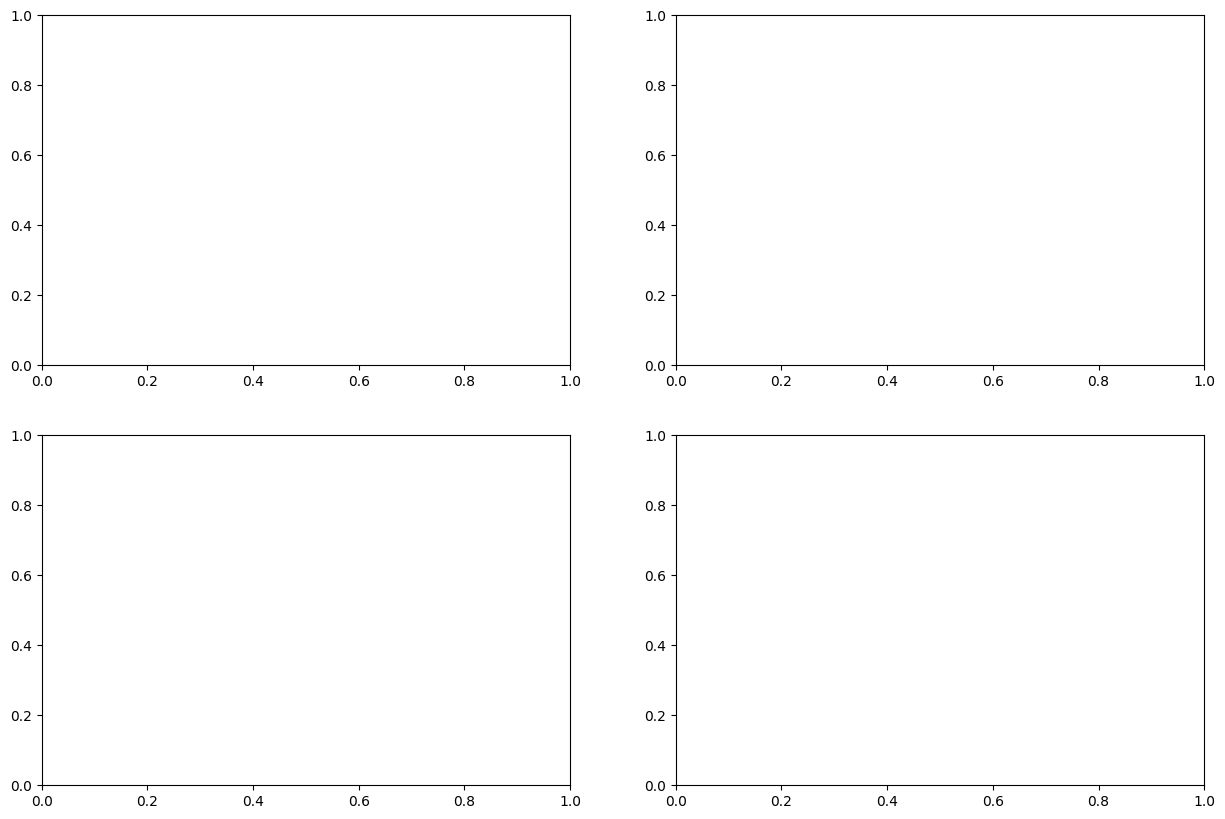

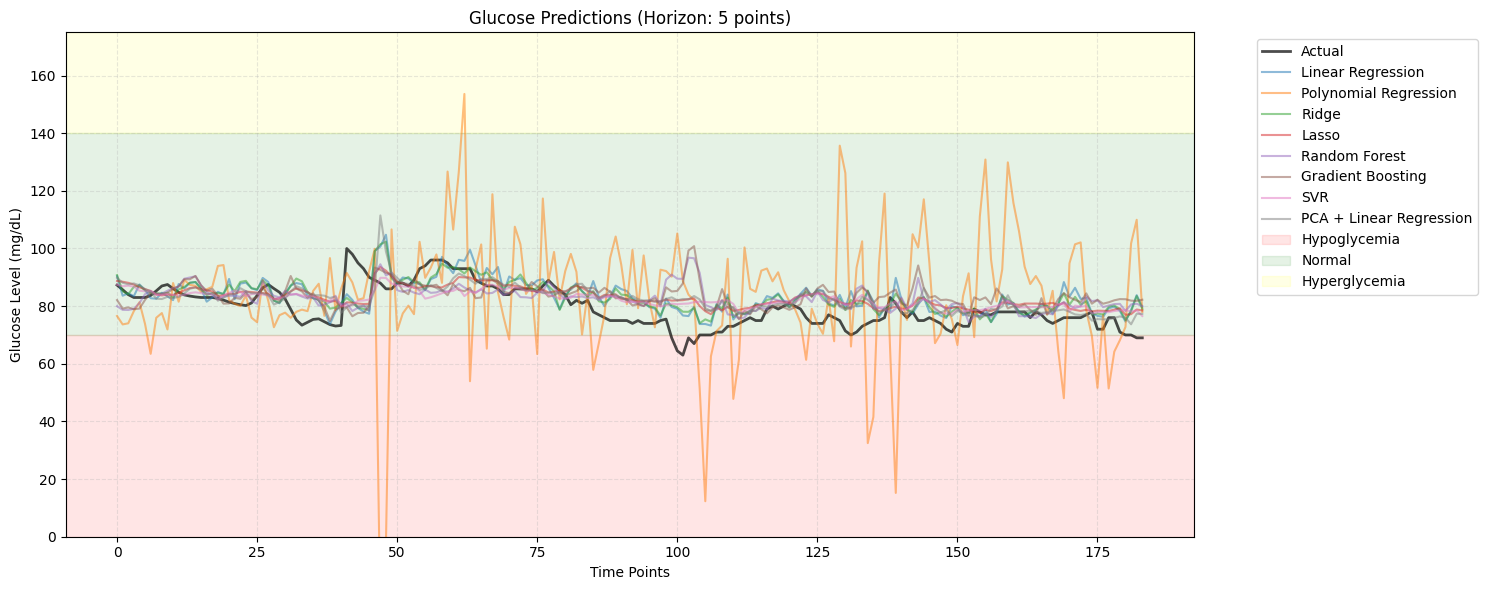


=== Training models with window size 5 and horizon 3 ===
Creating features with window size 5 and horizon 3
Feature creation time: 13.84 seconds

Training Linear Regression...
Linear Regression Performance:
MSE: 33.39
MAE: 4.50
R²: 0.33
Accuracy (±10 mg/dL): 92.93%
Training Time: 0.02 seconds
Prediction Time: 0.00 seconds

Training Polynomial Regression...
Polynomial Regression Performance:
MSE: 238.49
MAE: 11.97
R²: -3.75
Accuracy (±10 mg/dL): 53.26%
Training Time: 2.18 seconds
Prediction Time: 0.02 seconds

Training Ridge...
Ridge Performance:
MSE: 31.23
MAE: 4.37
R²: 0.38
Accuracy (±10 mg/dL): 93.48%
Training Time: 0.01 seconds
Prediction Time: 0.00 seconds

Training Lasso...
Lasso Performance:
MSE: 25.39
MAE: 3.80
R²: 0.49
Accuracy (±10 mg/dL): 96.74%
Training Time: 0.00 seconds
Prediction Time: 0.00 seconds

Training Random Forest...
Random Forest Performance:
MSE: 47.72
MAE: 4.79
R²: 0.05
Accuracy (±10 mg/dL): 90.22%
Training Time: 5.33 seconds
Prediction Time: 0.01 seconds

Tra

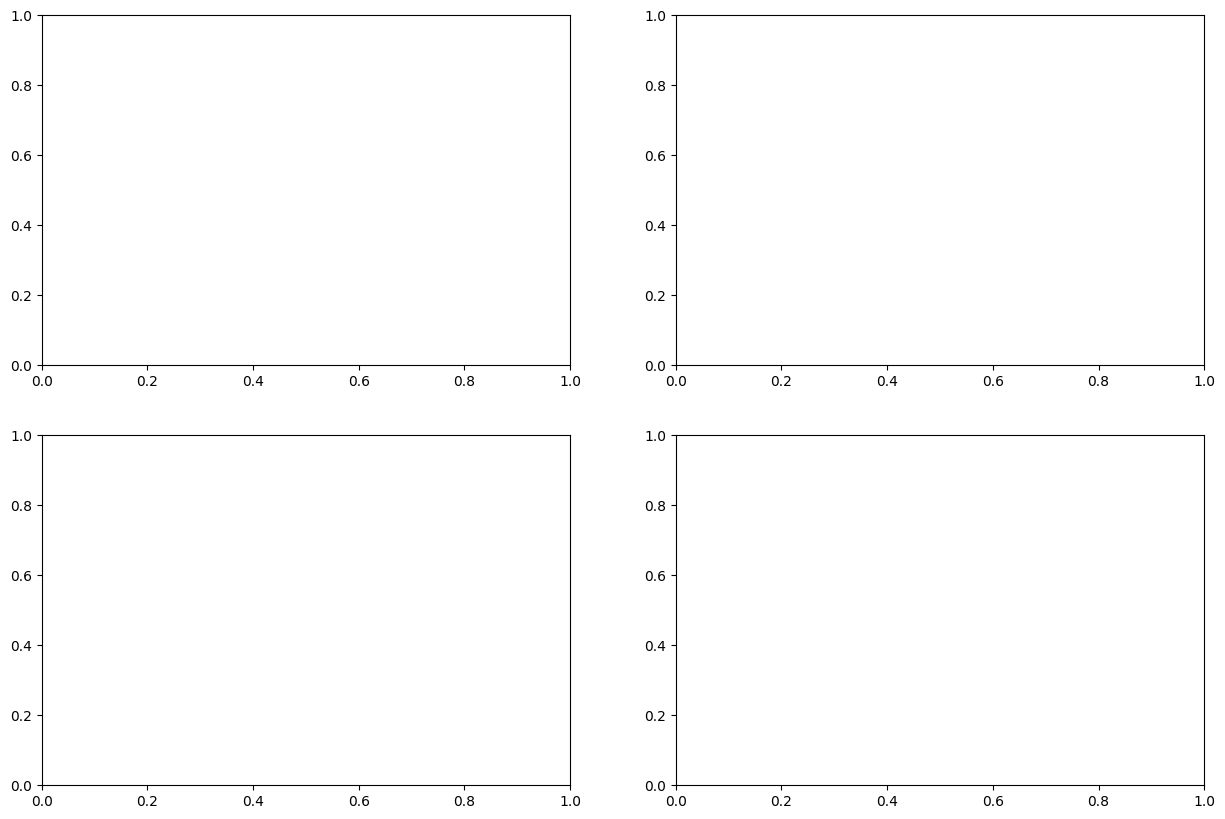

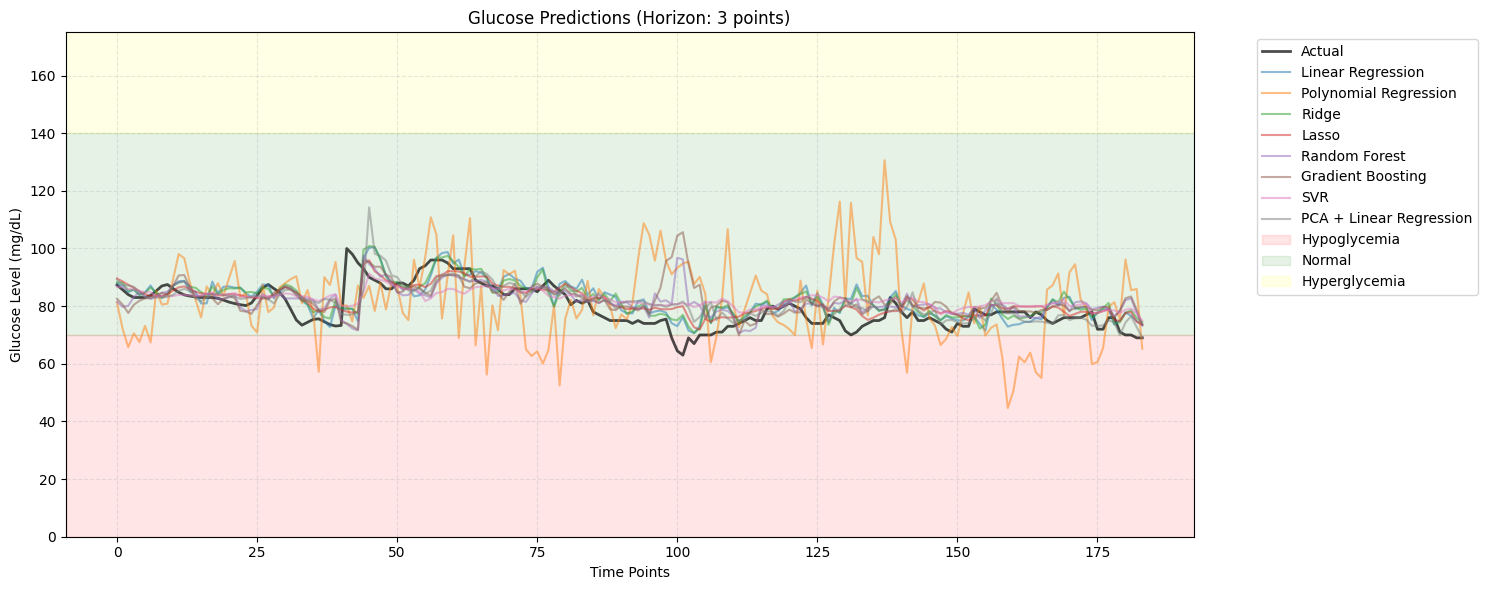


=== Training models with window size 5 and horizon 5 ===
Creating features with window size 5 and horizon 5
Feature creation time: 13.81 seconds

Training Linear Regression...
Linear Regression Performance:
MSE: 54.75
MAE: 6.07
R²: -0.09
Accuracy (±10 mg/dL): 80.33%
Training Time: 0.02 seconds
Prediction Time: 0.00 seconds

Training Polynomial Regression...
Polynomial Regression Performance:
MSE: 318.95
MAE: 14.05
R²: -5.36
Accuracy (±10 mg/dL): 39.34%
Training Time: 2.25 seconds
Prediction Time: 0.03 seconds

Training Ridge...
Ridge Performance:
MSE: 49.06
MAE: 5.88
R²: 0.02
Accuracy (±10 mg/dL): 85.25%
Training Time: 0.01 seconds
Prediction Time: 0.00 seconds

Training Lasso...
Lasso Performance:
MSE: 42.61
MAE: 5.30
R²: 0.15
Accuracy (±10 mg/dL): 89.62%
Training Time: 0.01 seconds
Prediction Time: 0.00 seconds

Training Random Forest...
Random Forest Performance:
MSE: 78.75
MAE: 6.61
R²: -0.57
Accuracy (±10 mg/dL): 81.97%
Training Time: 5.35 seconds
Prediction Time: 0.00 seconds

T

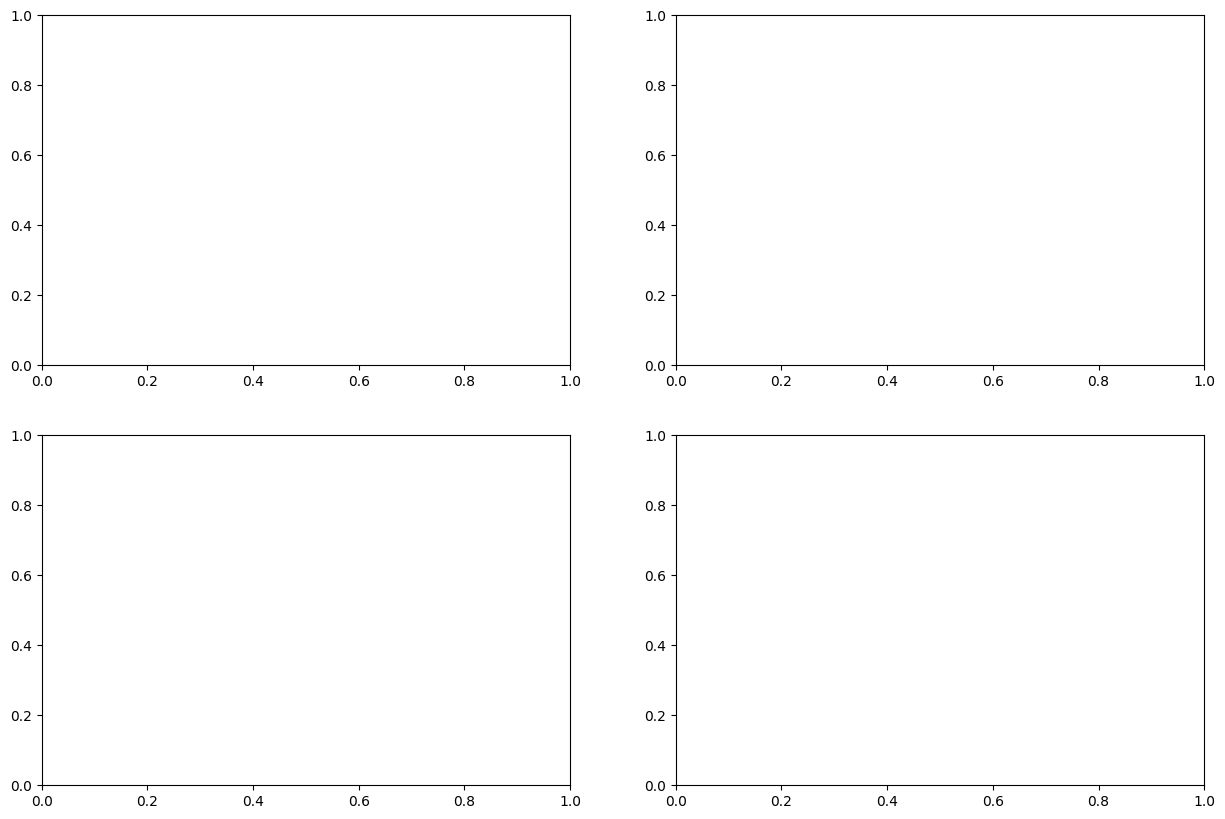

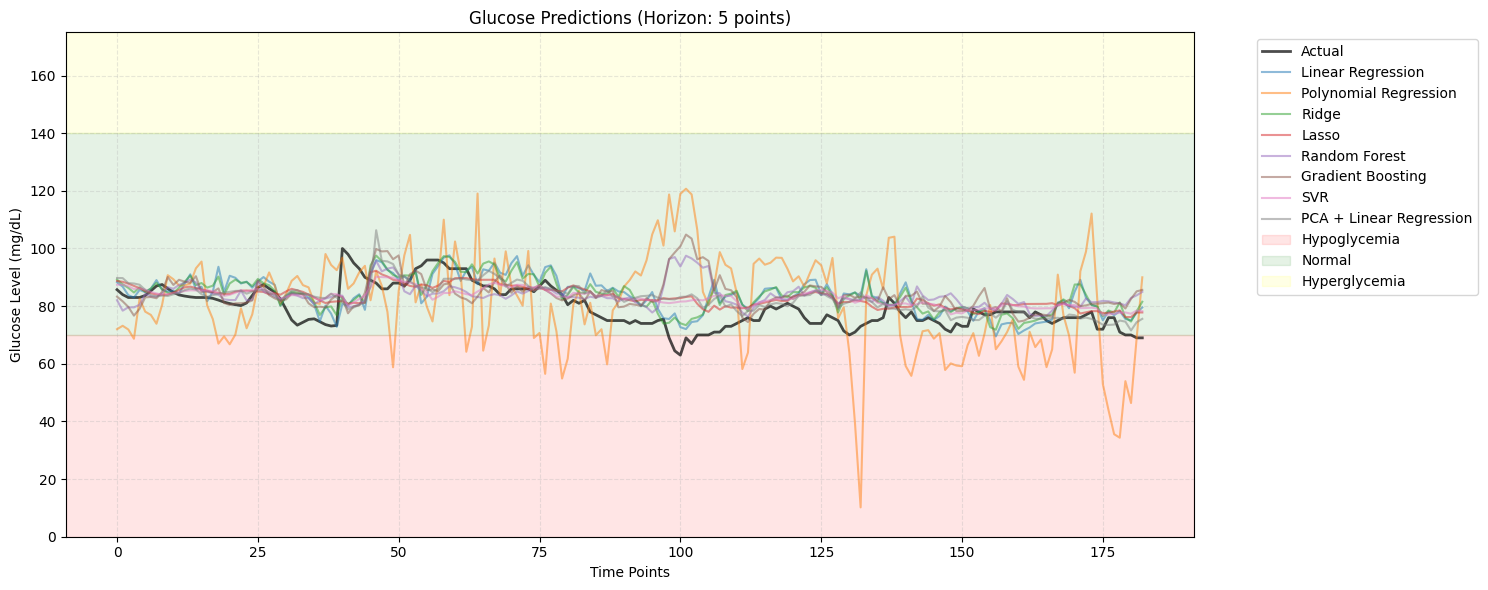


=== Training models with window size 10 and horizon 3 ===
Creating features with window size 10 and horizon 3
Feature creation time: 13.75 seconds

Training Linear Regression...
Linear Regression Performance:
MSE: 58.89
MAE: 6.01
R²: -0.17
Accuracy (±10 mg/dL): 78.69%
Training Time: 0.03 seconds
Prediction Time: 0.00 seconds

Training Polynomial Regression...
Polynomial Regression Performance:
MSE: 294.91
MAE: 13.19
R²: -4.88
Accuracy (±10 mg/dL): 49.18%
Training Time: 6.45 seconds
Prediction Time: 0.06 seconds

Training Ridge...
Ridge Performance:
MSE: 42.15
MAE: 5.17
R²: 0.16
Accuracy (±10 mg/dL): 87.98%
Training Time: 0.01 seconds
Prediction Time: 0.00 seconds

Training Lasso...
Lasso Performance:
MSE: 26.07
MAE: 3.88
R²: 0.48
Accuracy (±10 mg/dL): 97.27%
Training Time: 0.00 seconds
Prediction Time: 0.00 seconds

Training Random Forest...
Random Forest Performance:
MSE: 46.16
MAE: 4.76
R²: 0.08
Accuracy (±10 mg/dL): 89.07%
Training Time: 7.37 seconds
Prediction Time: 0.00 seconds



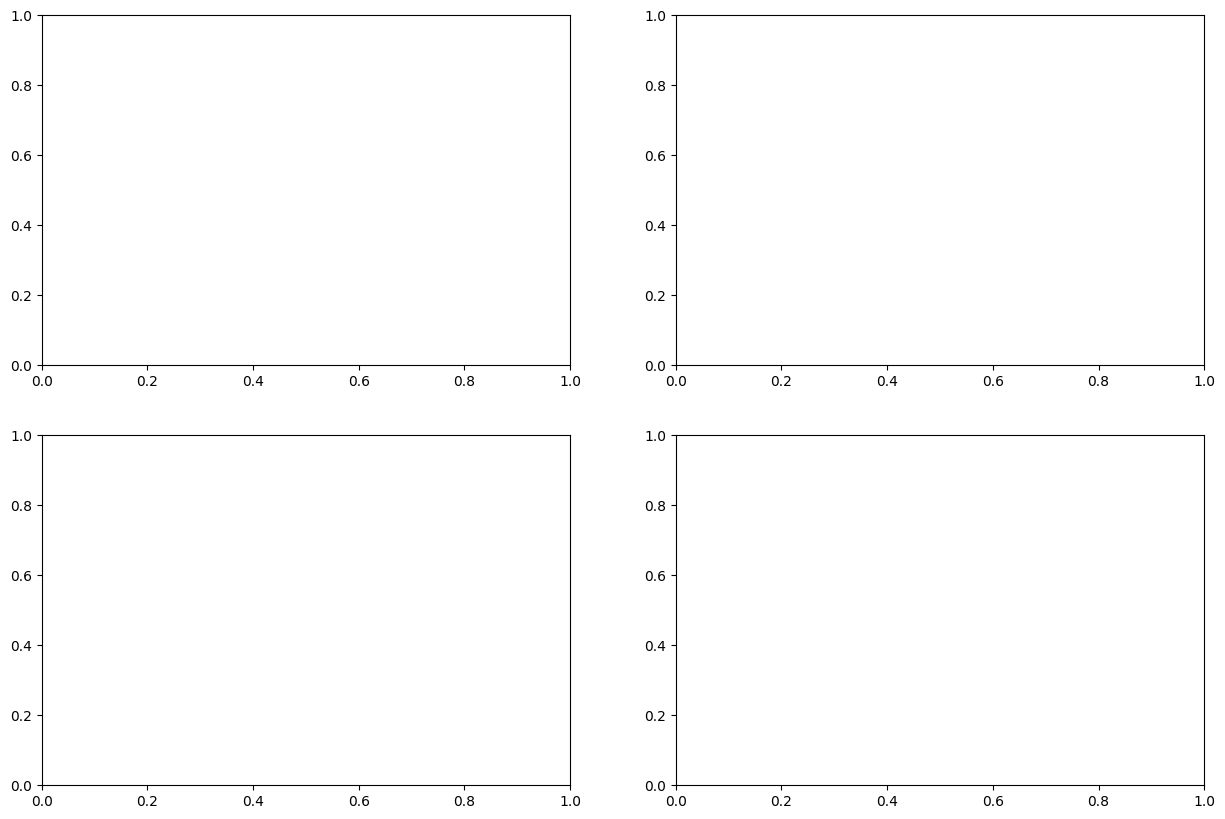

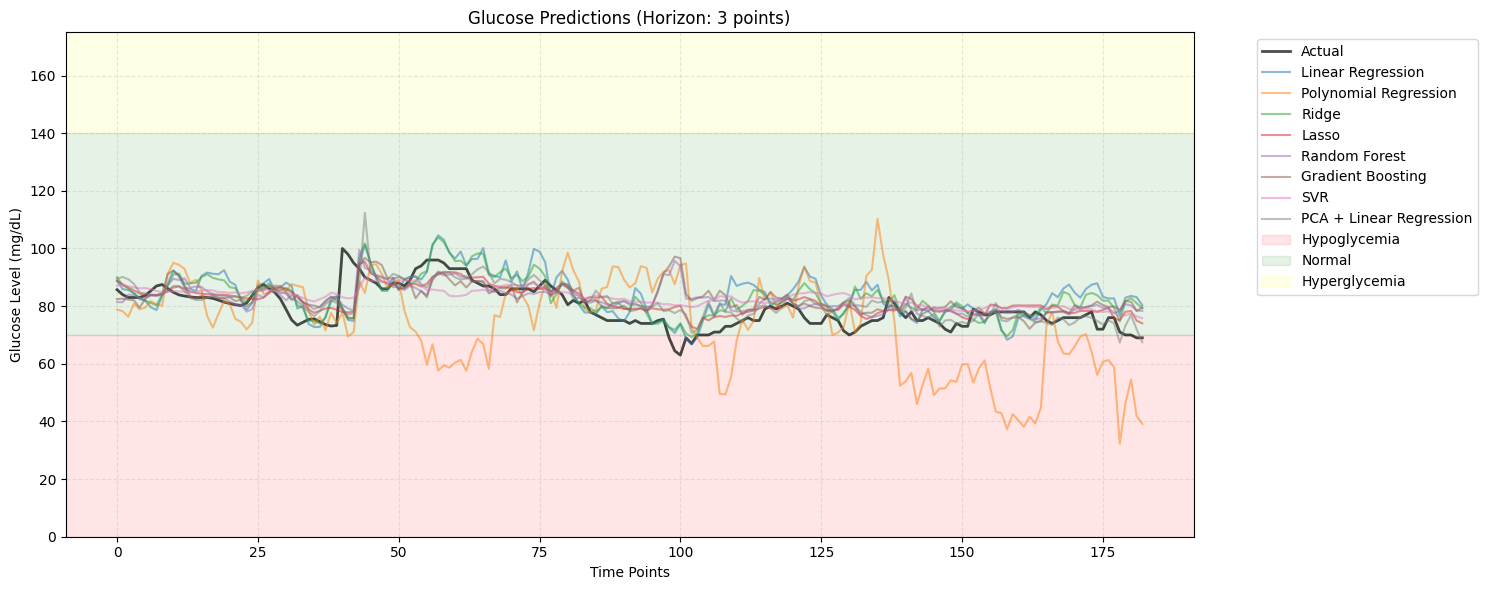


=== Training models with window size 10 and horizon 5 ===
Creating features with window size 10 and horizon 5
Feature creation time: 13.59 seconds

Training Linear Regression...
Linear Regression Performance:
MSE: 81.80
MAE: 7.53
R²: -0.63
Accuracy (±10 mg/dL): 69.23%
Training Time: 0.03 seconds
Prediction Time: 0.00 seconds

Training Polynomial Regression...
Polynomial Regression Performance:
MSE: 783.88
MAE: 21.29
R²: -14.61
Accuracy (±10 mg/dL): 37.91%
Training Time: 6.41 seconds
Prediction Time: 0.08 seconds

Training Ridge...
Ridge Performance:
MSE: 56.59
MAE: 6.42
R²: -0.13
Accuracy (±10 mg/dL): 80.77%
Training Time: 0.01 seconds
Prediction Time: 0.01 seconds

Training Lasso...
Lasso Performance:
MSE: 42.96
MAE: 5.31
R²: 0.14
Accuracy (±10 mg/dL): 89.56%
Training Time: 0.01 seconds
Prediction Time: 0.01 seconds

Training Random Forest...
Random Forest Performance:
MSE: 65.95
MAE: 6.26
R²: -0.31
Accuracy (±10 mg/dL): 83.52%
Training Time: 7.58 seconds
Prediction Time: 0.00 second

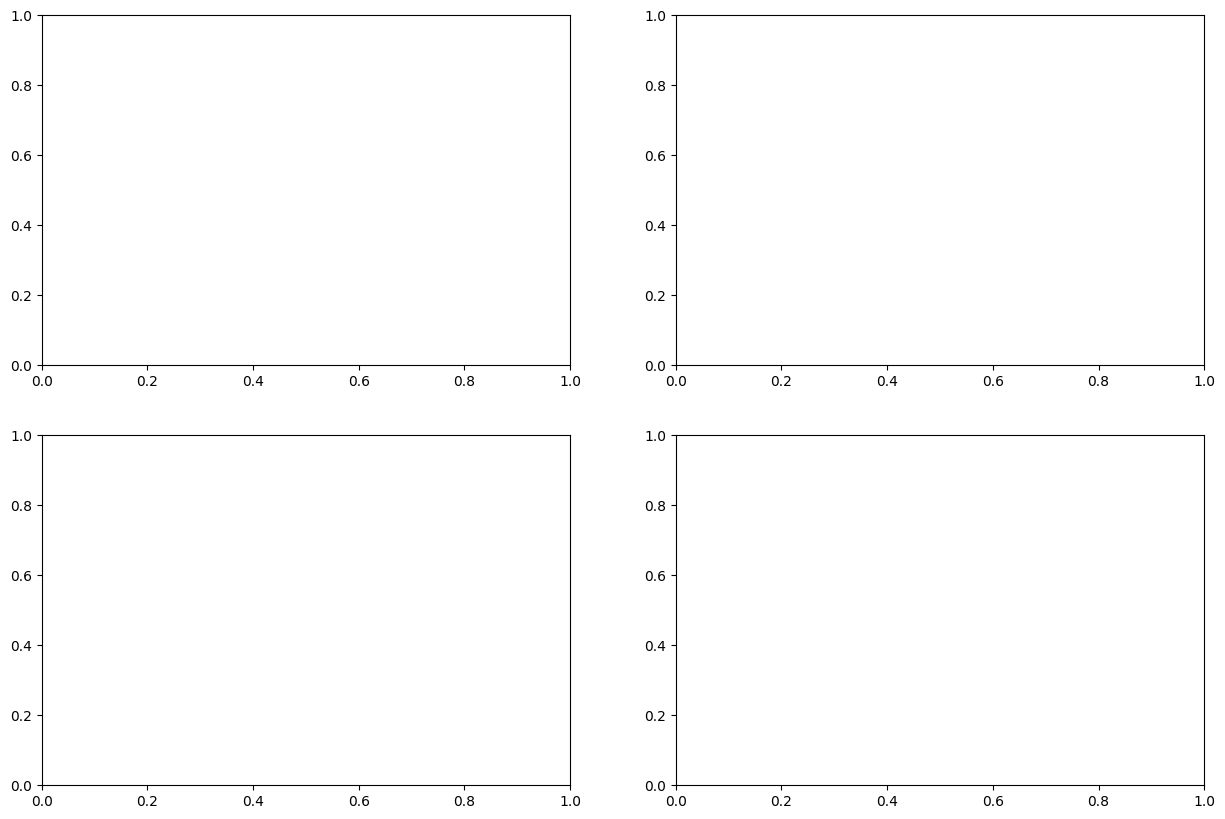

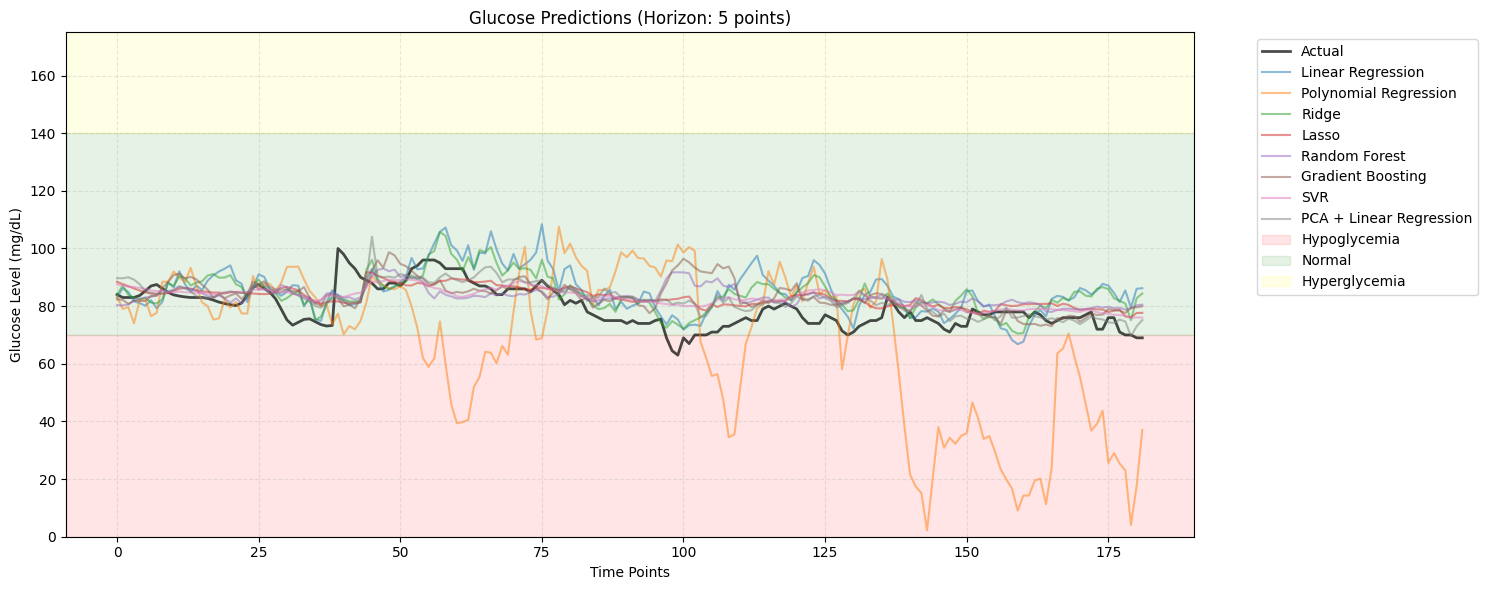


Comprehensive Model Summary:

Window Size: 3, Prediction Horizon: 3
Best Model: Lasso
Accuracy: 97.28%
R² Score: 0.49
MSE: 25.40
MAE: 3.79
Training Time: 0.00 seconds
Prediction Time: 0.00 seconds

Window Size: 3, Prediction Horizon: 5
Best Model: Lasso
Accuracy: 90.22%
R² Score: 0.17
MSE: 41.49
MAE: 5.22
Training Time: 0.00 seconds
Prediction Time: 0.01 seconds

Window Size: 5, Prediction Horizon: 3
Best Model: Lasso
Accuracy: 96.74%
R² Score: 0.49
MSE: 25.39
MAE: 3.80
Training Time: 0.00 seconds
Prediction Time: 0.00 seconds

Window Size: 5, Prediction Horizon: 5
Best Model: Lasso
Accuracy: 89.62%
R² Score: 0.15
MSE: 42.61
MAE: 5.30
Training Time: 0.01 seconds
Prediction Time: 0.00 seconds

Window Size: 10, Prediction Horizon: 3
Best Model: Lasso
Accuracy: 97.27%
R² Score: 0.48
MSE: 26.07
MAE: 3.88
Training Time: 0.00 seconds
Prediction Time: 0.00 seconds

Window Size: 10, Prediction Horizon: 5
Best Model: PCA + Linear Regression
Accuracy: 90.11%
R² Score: 0.21
MSE: 39.47
MAE: 4.91


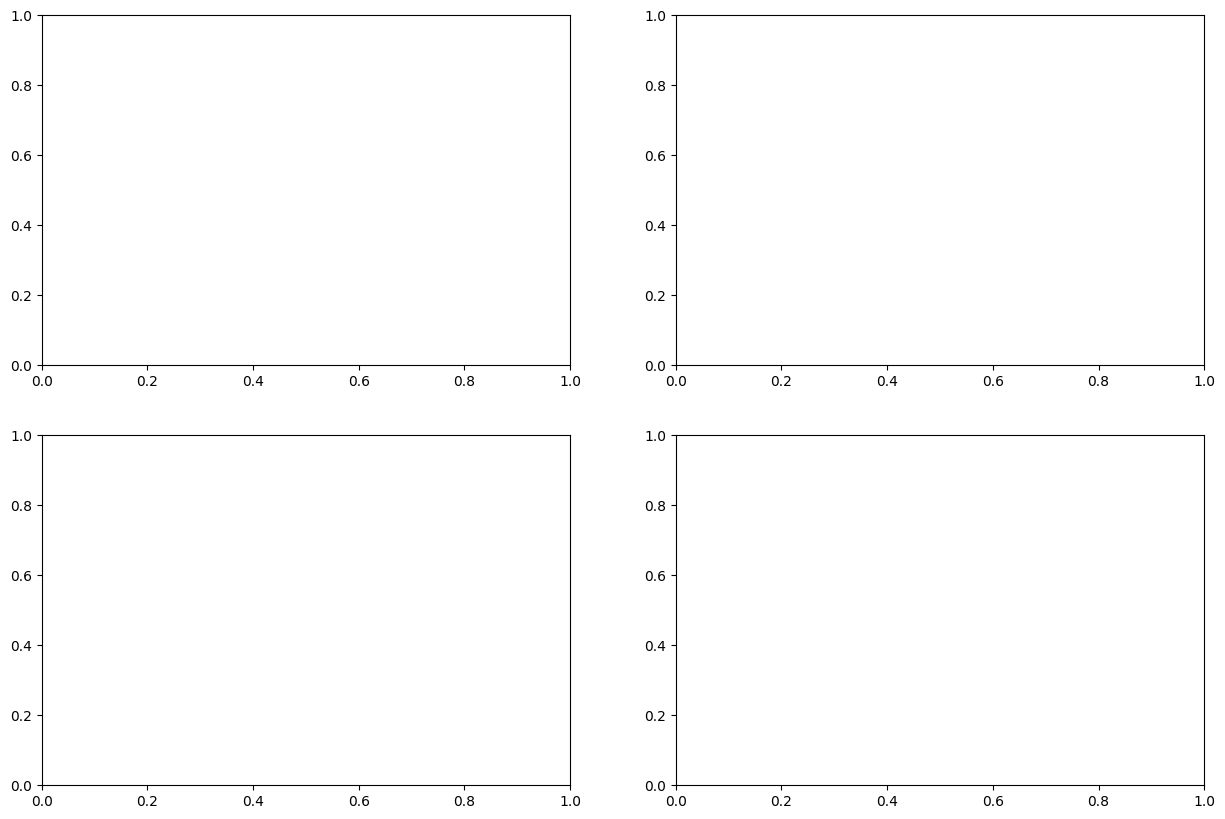

In [13]:
# Train models with different configurations
window_sizes = [3, 5, 10] # Represents the number of historical time points used to make a prediction
prediction_horizons = [3, 5] #Represents how far into the future the model tries to predict 

best_results = {}
for w in window_sizes:
    for h in prediction_horizons:
        print(f"\n=== Training models with window size {w} and horizon {h} ===")
        predictor = GlucosePredictorGPU(window_size=w, prediction_horizon=h)
        results = predictor.train_and_evaluate(filtered_data)
        
        # Store best model for this configuration
        best_model = max(results.items(), key=lambda x: x[1]['r2'])
        best_results[(w, h)] = {
            'model': best_model[0],
            'metrics': best_model[1]
        }

# Print comprehensive summary
print("\nComprehensive Model Summary:")
for (w, h), result in best_results.items():
    print(f"\nWindow Size: {w}, Prediction Horizon: {h}")
    print(f"Best Model: {result['model']}")
    print(f"Accuracy: {result['metrics']['accuracy']:.2f}%")
    print(f"R² Score: {result['metrics']['r2']:.2f}")
    print(f"MSE: {result['metrics']['mse']:.2f}")
    print(f"MAE: {result['metrics']['mae']:.2f}")
    print(f"Training Time: {result['metrics']['training_time']:.2f} seconds")
    print(f"Prediction Time: {result['metrics']['prediction_time']:.2f} seconds")

Lasso performs best overall with highest accuracy and R²<br>
Simple models (Lasso, Ridge) outperform complex ones<br>
Polynomial Regression performed poorly (overfitting)<br>
Most models achieve >90% accuracy within ±10 mg/dL<br>

Found 7 days with >75 data points

Trend Agreement Stats for 2024-09-02 - Lasso:
Agreement Rate: 33.3%
Peaks Detected: Actual=4, Predicted=0
Valleys Detected: Actual=3, Predicted=0

Trend Agreement Stats for 2024-09-02 - Lasso:
Agreement Rate: 79.6%
Peaks Detected: Actual=4, Predicted=0
Valleys Detected: Actual=3, Predicted=0


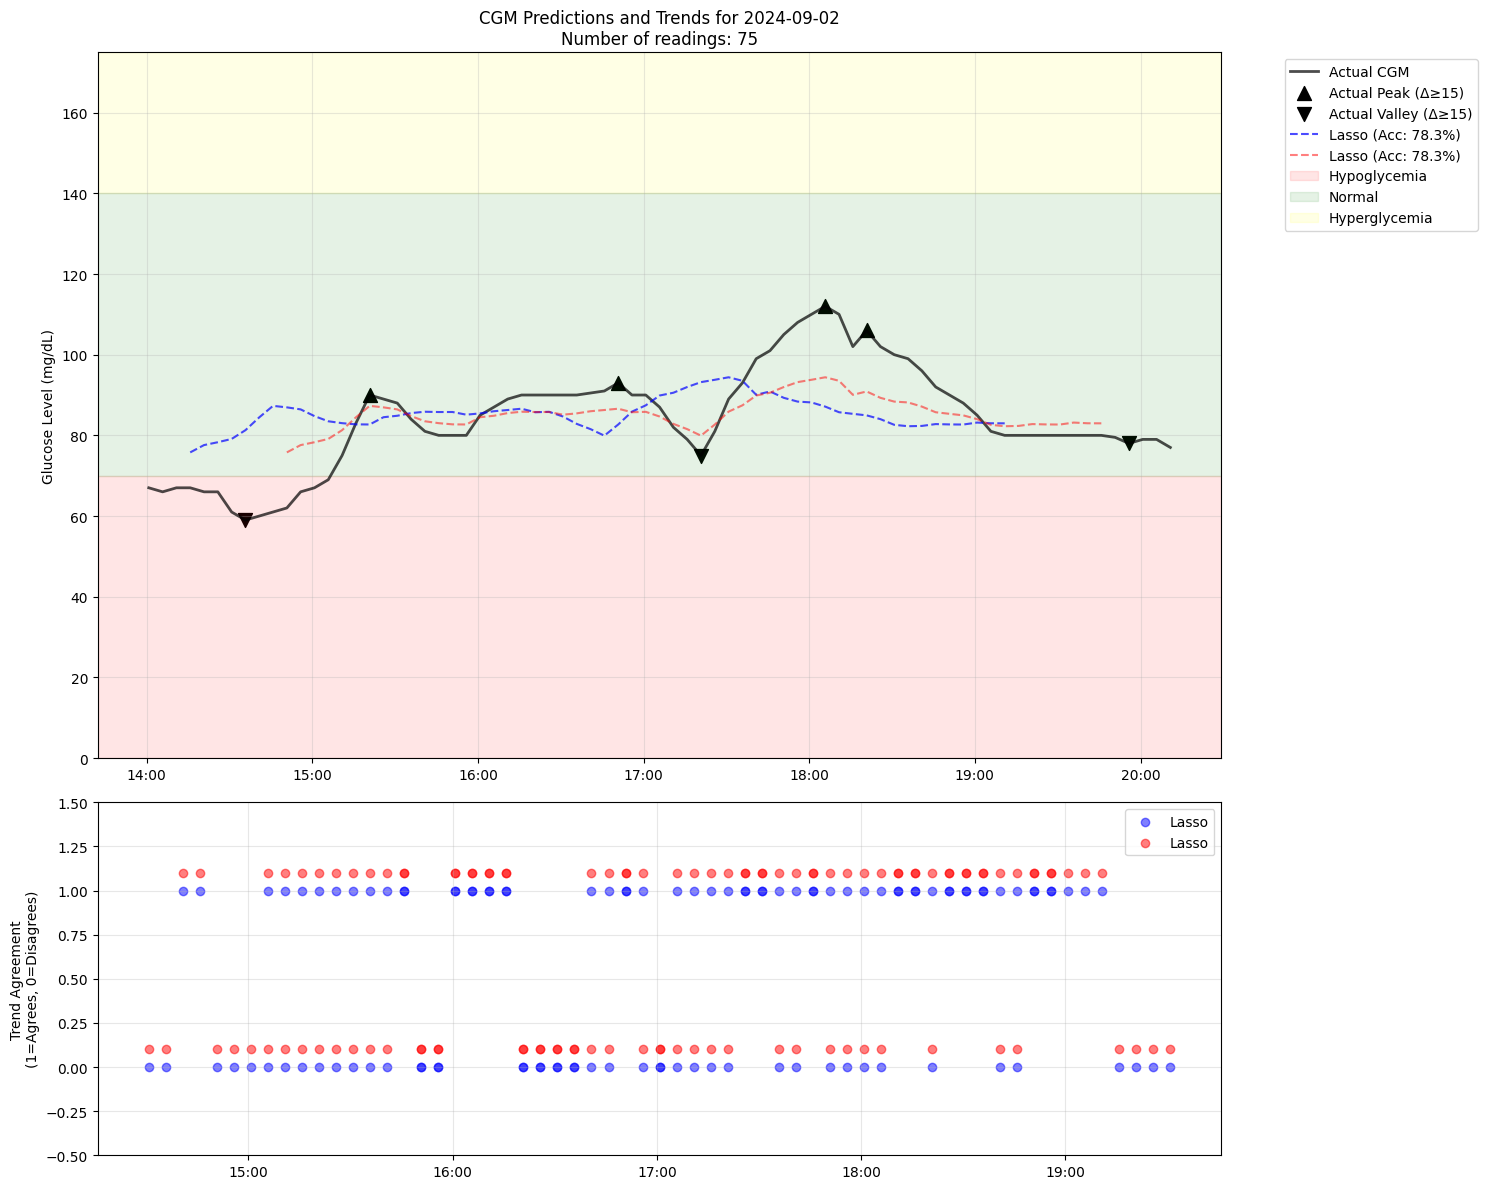


Trend Agreement Stats for 2024-09-04 - Lasso:
Agreement Rate: 24.1%
Peaks Detected: Actual=0, Predicted=0
Valleys Detected: Actual=0, Predicted=0

Trend Agreement Stats for 2024-09-04 - Lasso:
Agreement Rate: 70.4%
Peaks Detected: Actual=0, Predicted=0
Valleys Detected: Actual=0, Predicted=0


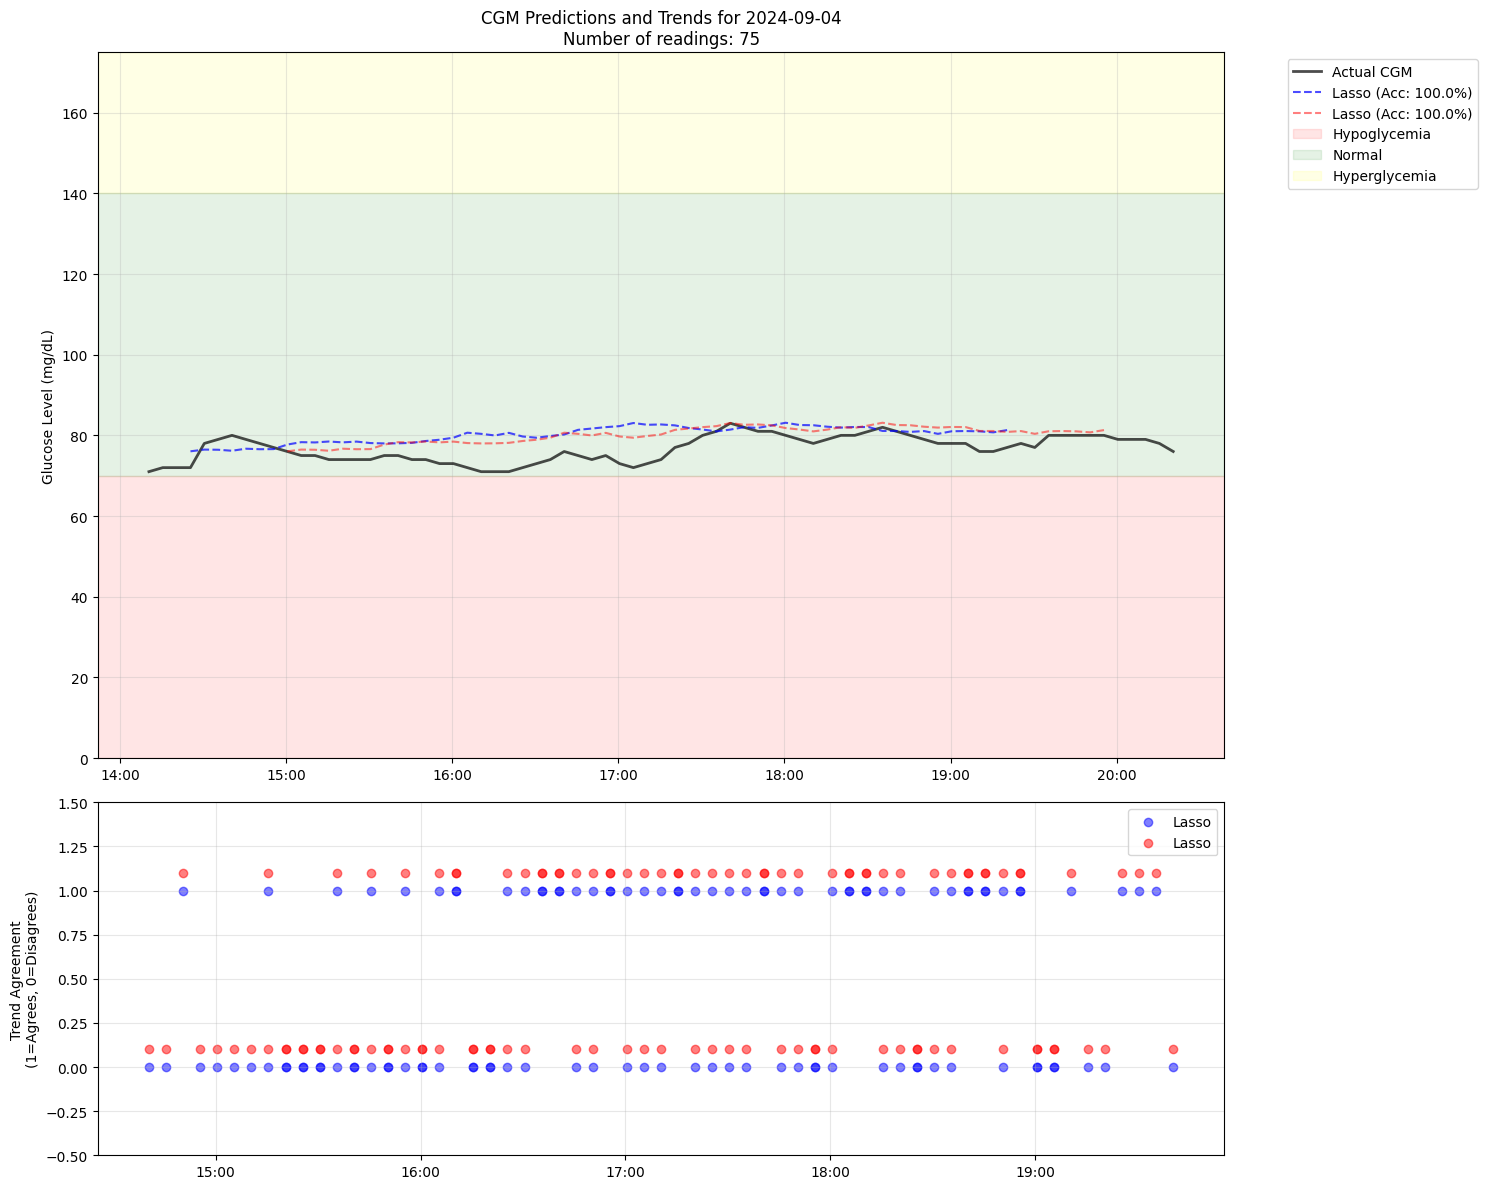


Trend Agreement Stats for 2024-11-27 - Lasso:
Agreement Rate: 40.7%
Peaks Detected: Actual=1, Predicted=0
Valleys Detected: Actual=1, Predicted=0

Trend Agreement Stats for 2024-11-27 - Lasso:
Agreement Rate: 79.0%
Peaks Detected: Actual=1, Predicted=0
Valleys Detected: Actual=1, Predicted=0


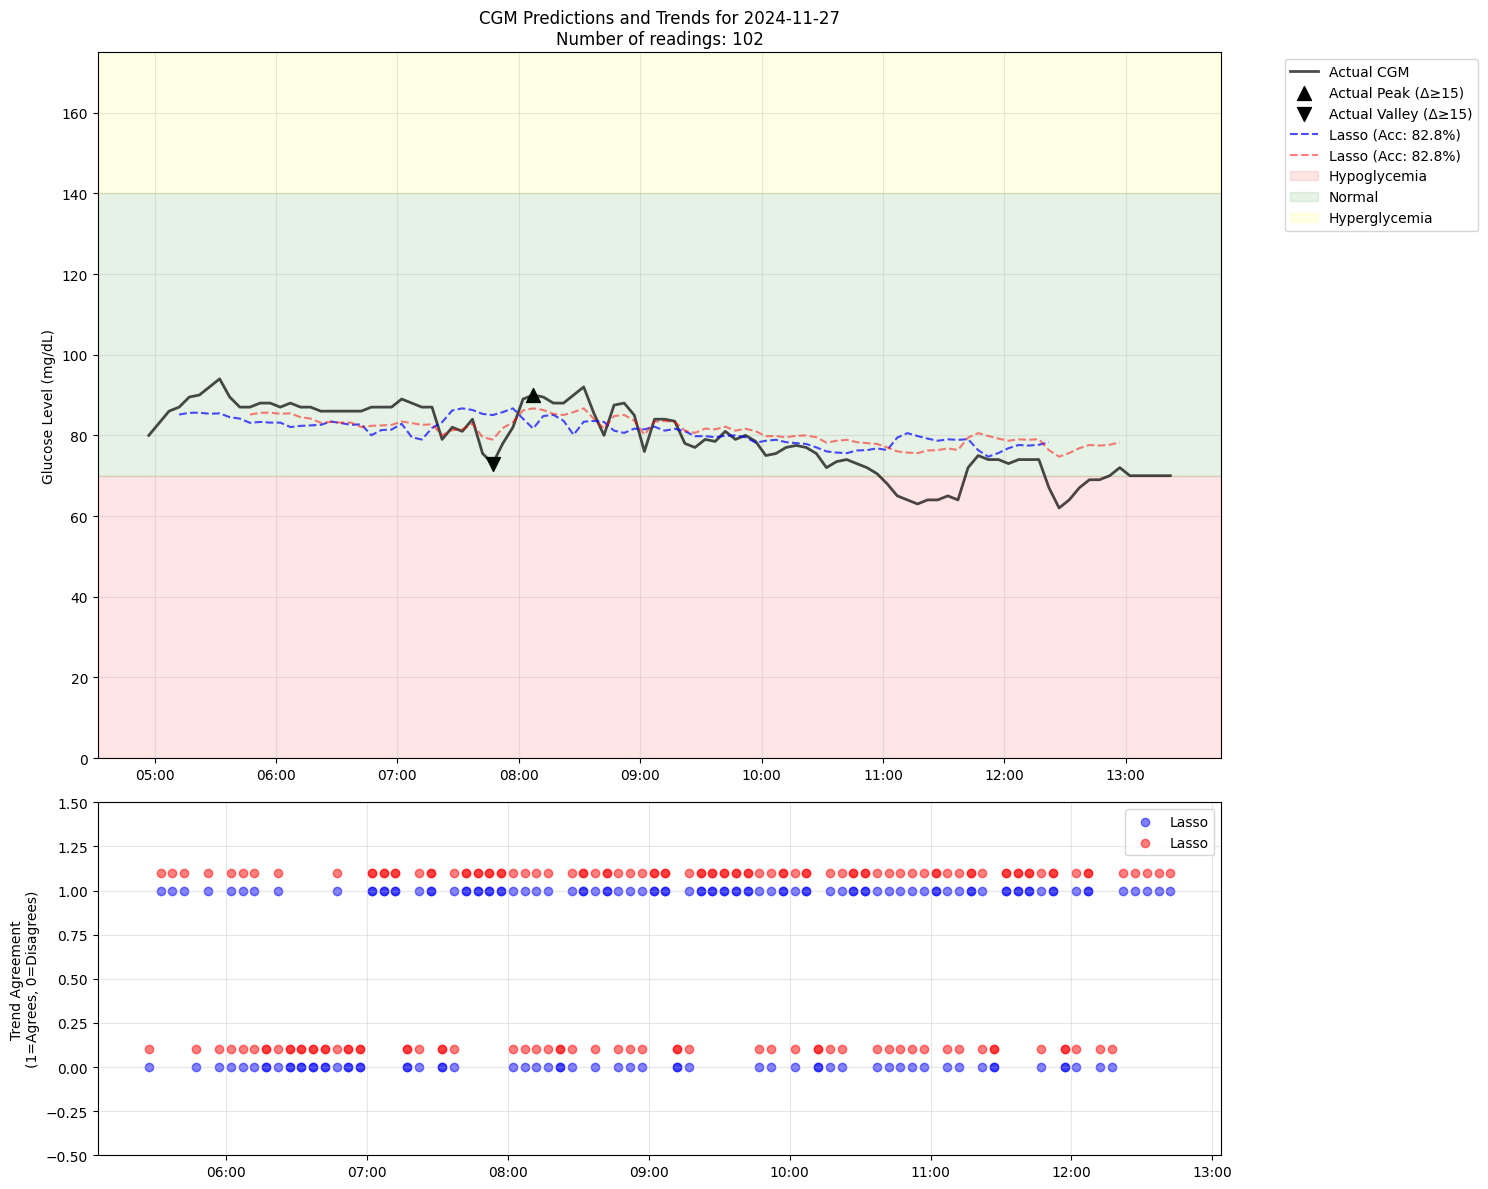


Trend Agreement Stats for 2024-11-29 - Lasso:
Agreement Rate: 35.1%
Peaks Detected: Actual=8, Predicted=0
Valleys Detected: Actual=9, Predicted=0

Trend Agreement Stats for 2024-11-29 - Lasso:
Agreement Rate: 84.0%
Peaks Detected: Actual=8, Predicted=0
Valleys Detected: Actual=9, Predicted=0


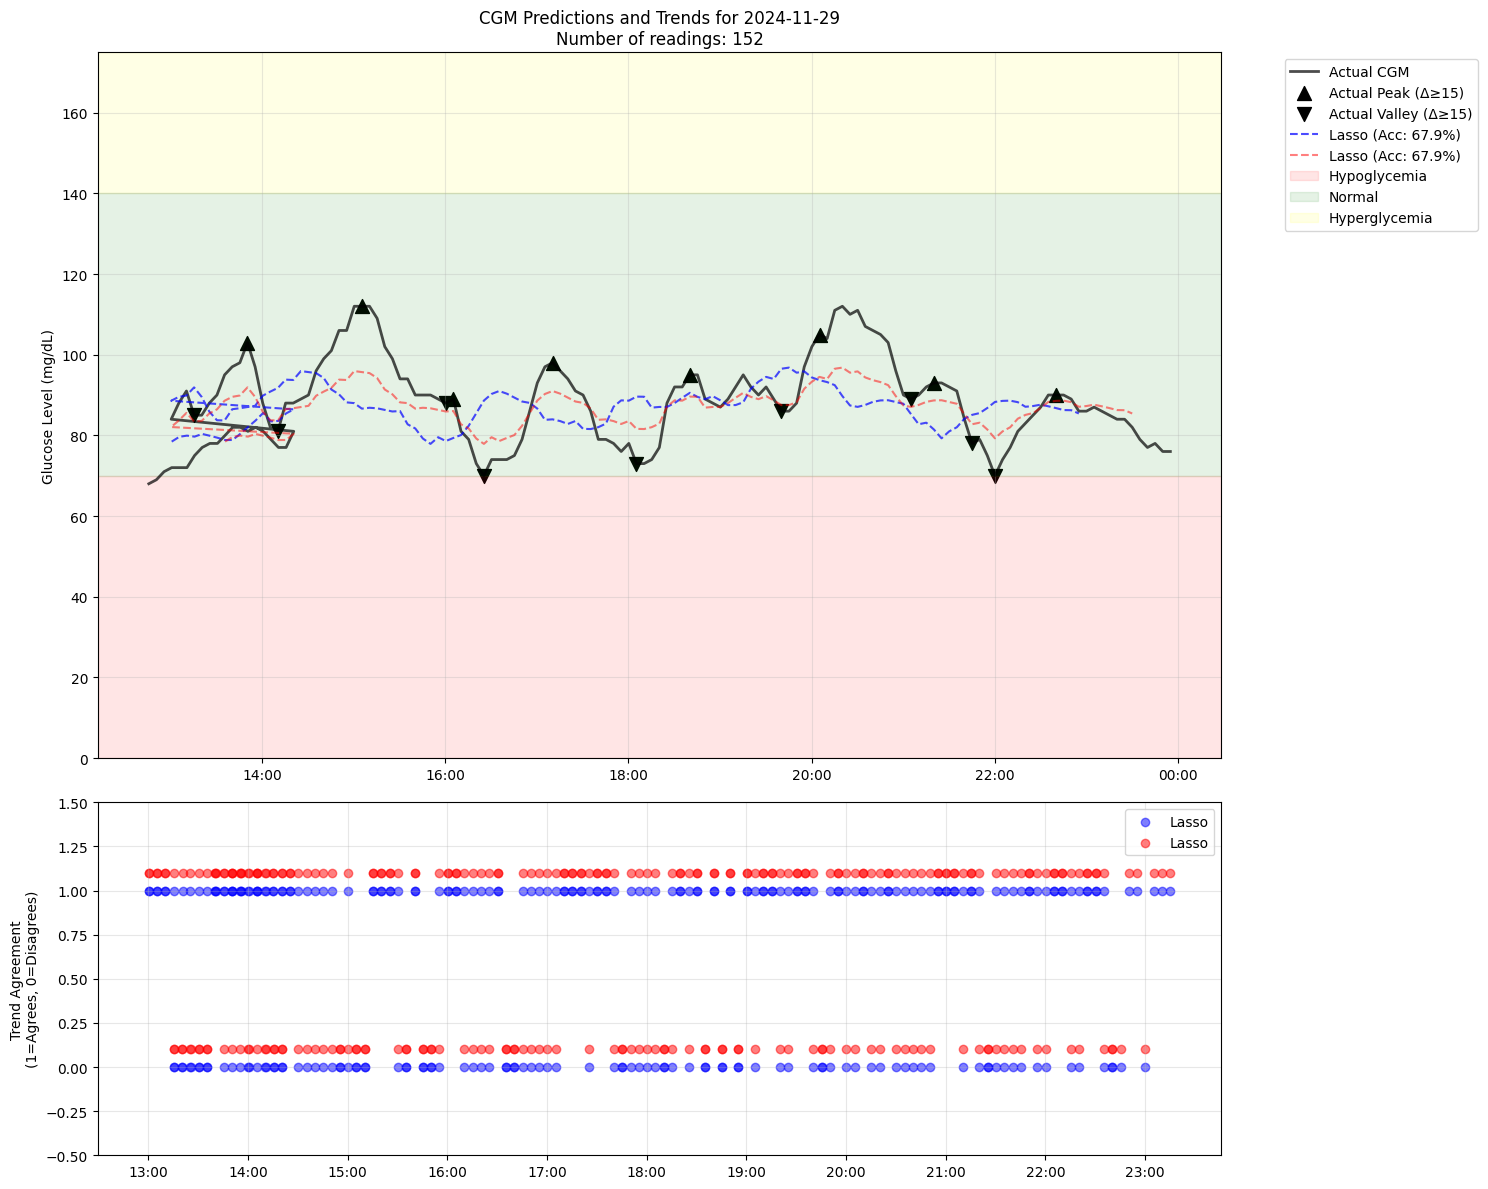


Trend Agreement Stats for 2024-12-01 - Lasso:
Agreement Rate: 41.0%
Peaks Detected: Actual=0, Predicted=0
Valleys Detected: Actual=0, Predicted=0

Trend Agreement Stats for 2024-12-01 - Lasso:
Agreement Rate: 70.5%
Peaks Detected: Actual=0, Predicted=0
Valleys Detected: Actual=0, Predicted=0


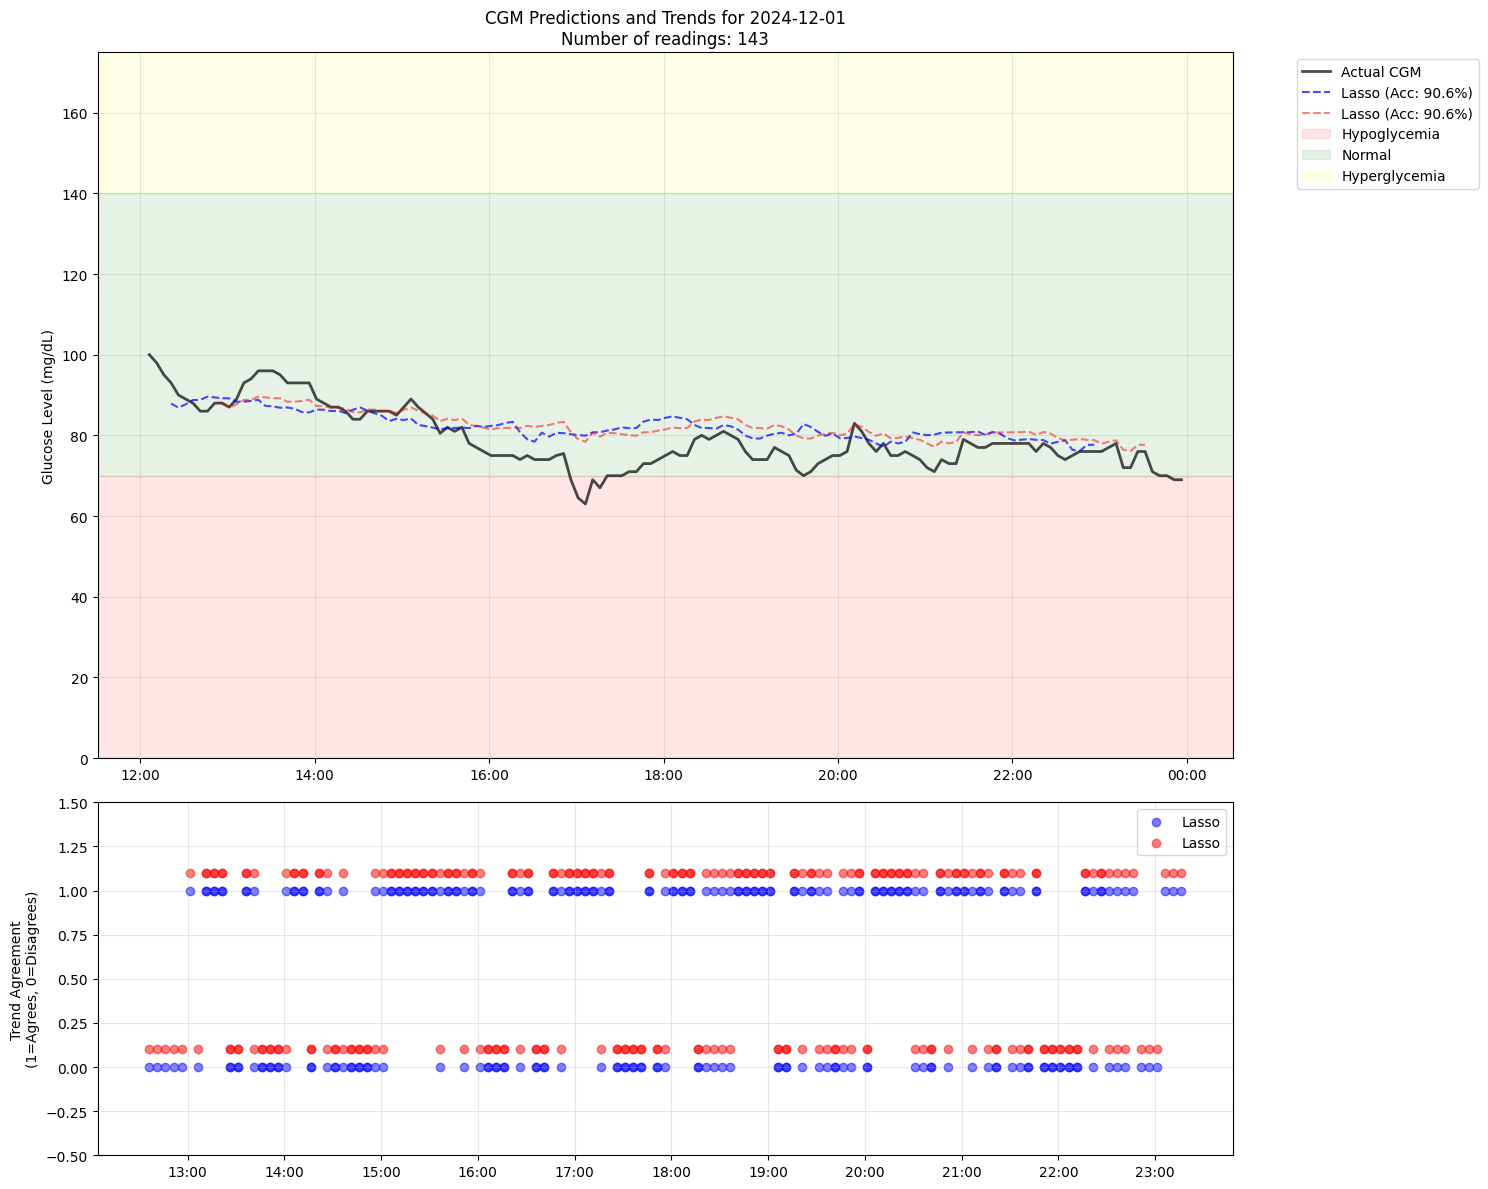


Trend Agreement Stats for 2024-12-04 - Lasso:
Agreement Rate: 39.8%
Peaks Detected: Actual=6, Predicted=1
Valleys Detected: Actual=9, Predicted=1

Trend Agreement Stats for 2024-12-04 - Lasso:
Agreement Rate: 86.4%
Peaks Detected: Actual=6, Predicted=1
Valleys Detected: Actual=9, Predicted=1


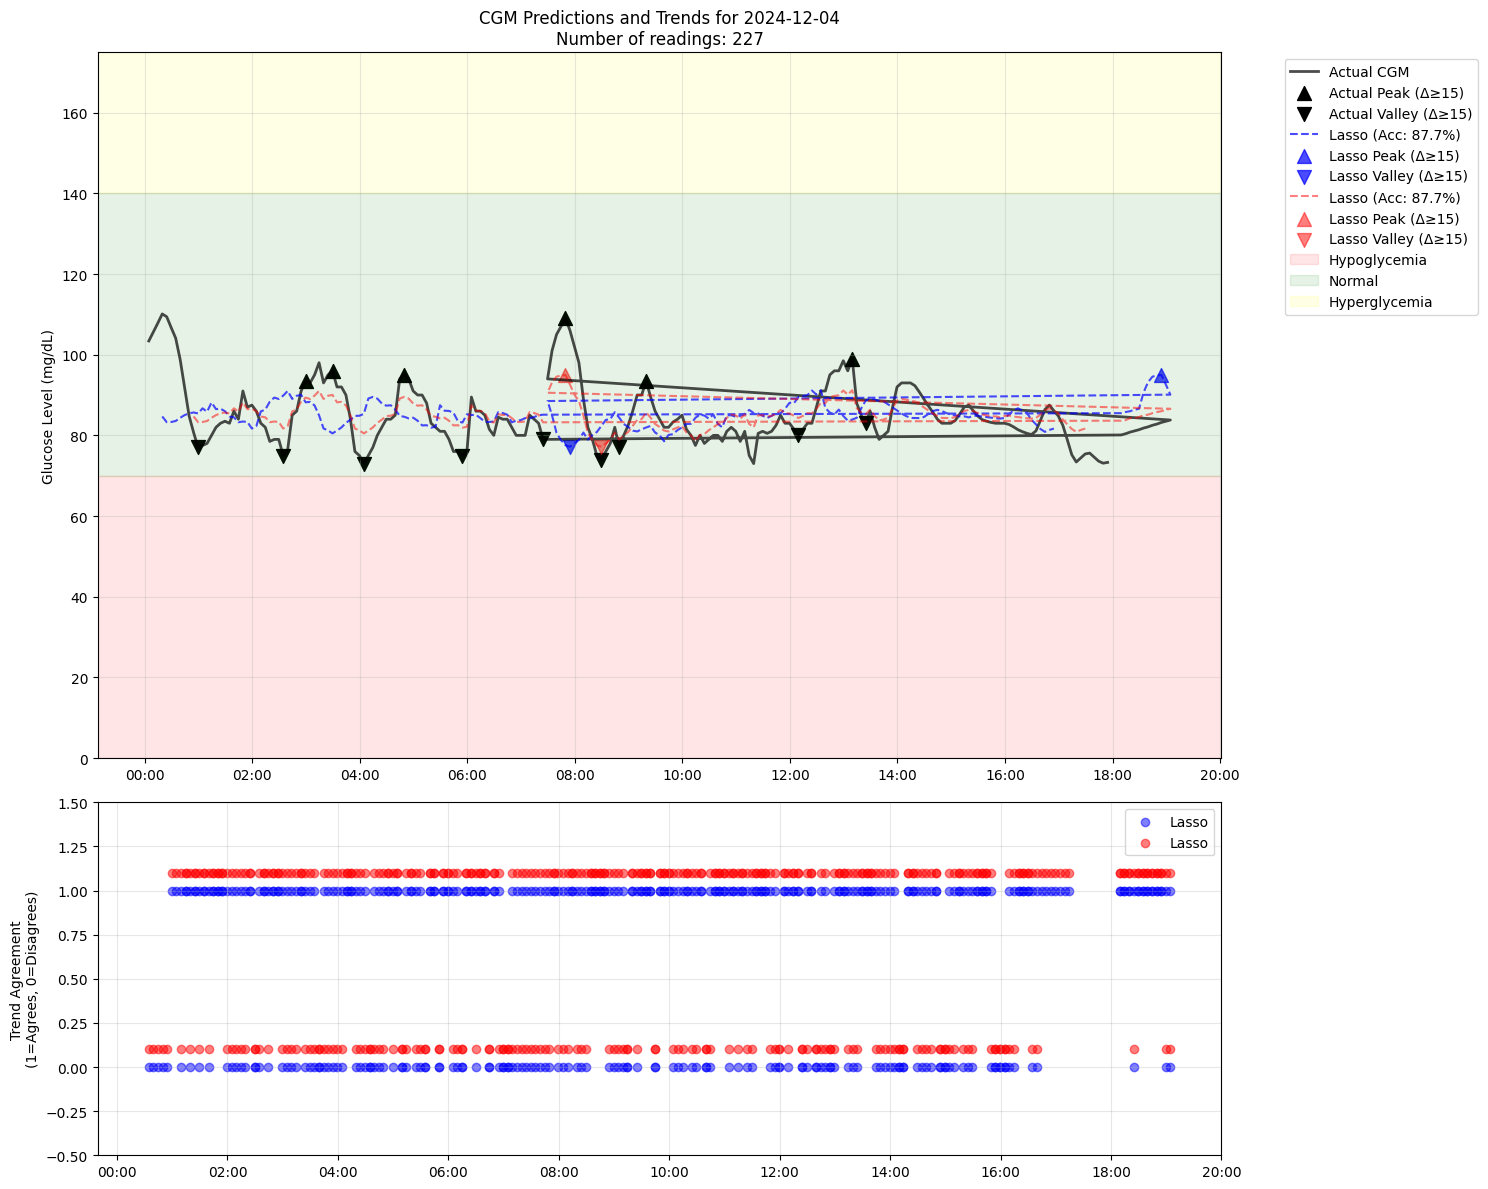


Trend Agreement Stats for 2024-12-05 - Lasso:
Agreement Rate: 47.3%
Peaks Detected: Actual=4, Predicted=0
Valleys Detected: Actual=5, Predicted=0

Trend Agreement Stats for 2024-12-05 - Lasso:
Agreement Rate: 82.2%
Peaks Detected: Actual=4, Predicted=0
Valleys Detected: Actual=5, Predicted=0


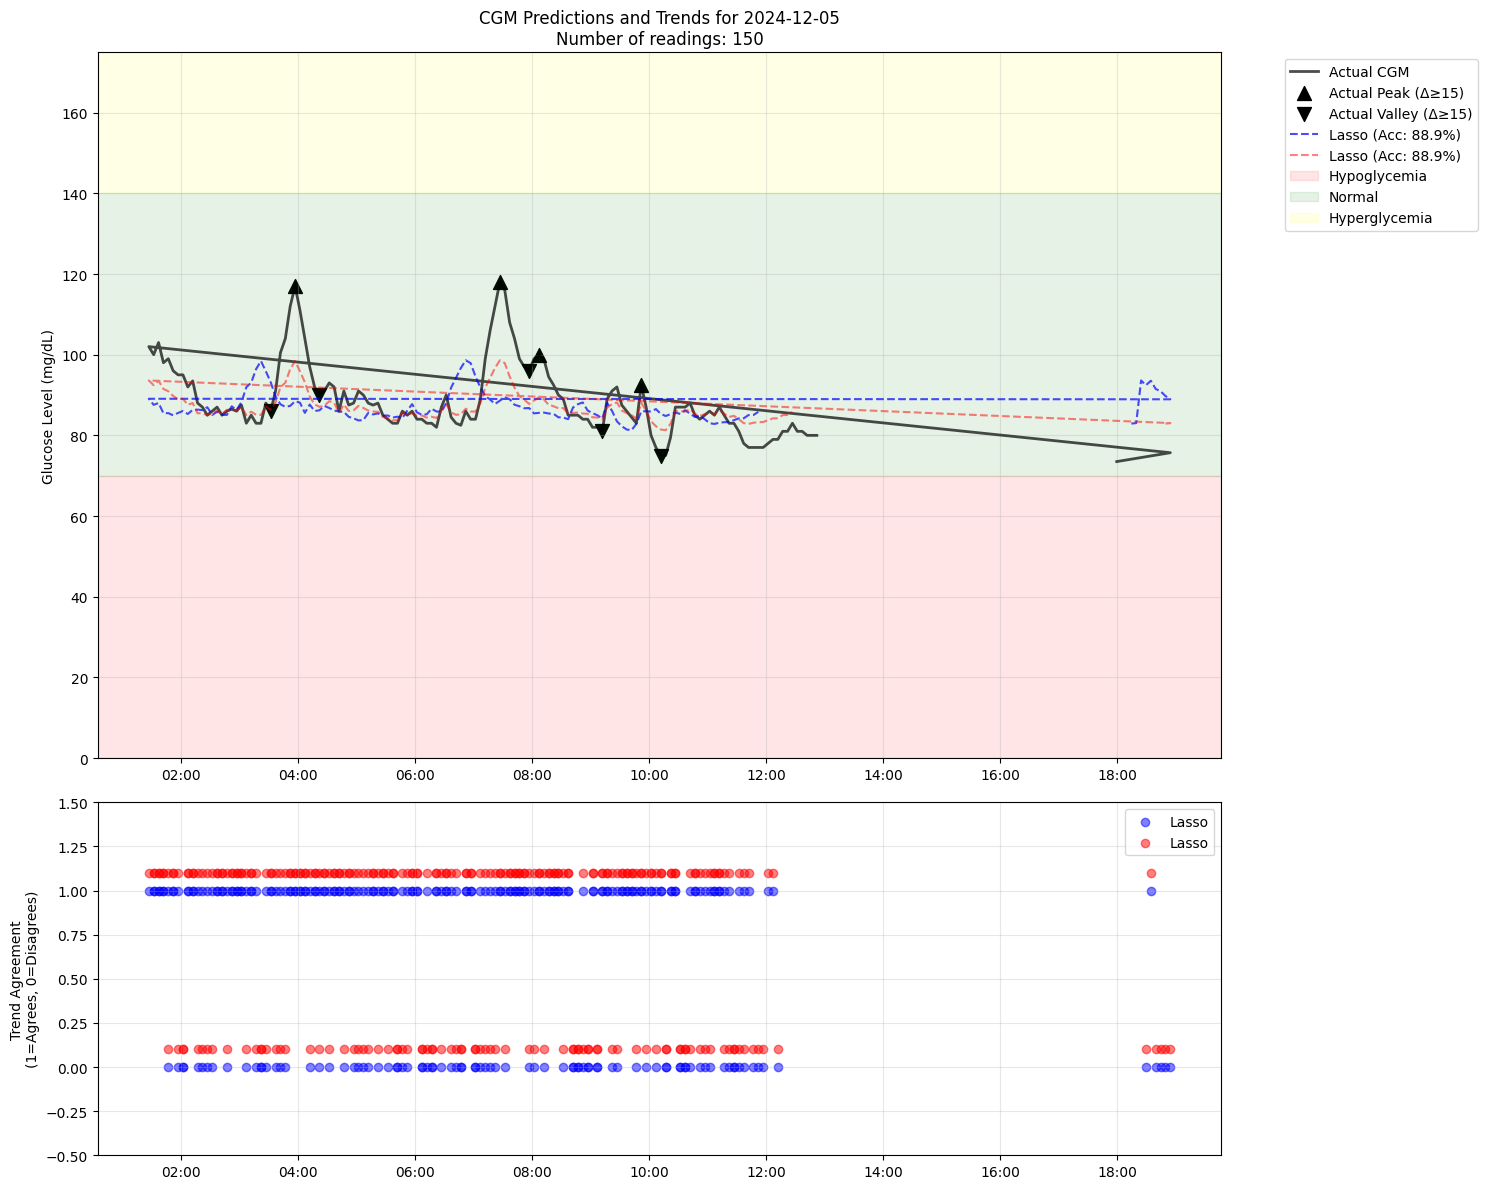

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import find_peaks
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

def find_significant_peaks_valleys(values, timestamps, min_change=20, distance=3):
    """Find peaks and valleys with significant changes (≥min_change mg/dL)"""
    peaks, _ = find_peaks(values, distance=distance)
    valleys, _ = find_peaks(-values, distance=distance)
    
    significant_peaks = []
    significant_valleys = []
    
    # Check each peak
    for peak in peaks:
        prev_valleys = [v for v in valleys if v < peak]
        next_valleys = [v for v in valleys if v > peak]
        
        if prev_valleys and next_valleys:
            nearest_prev = max(prev_valleys)
            nearest_next = min(next_valleys)
            
            prev_change = values[peak] - values[nearest_prev]
            next_change = values[peak] - values[nearest_next]
            
            if max(prev_change, next_change) >= min_change:
                significant_peaks.append(peak)
    
    # Check each valley
    for valley in valleys:
        prev_peaks = [p for p in peaks if p < valley]
        next_peaks = [p for p in peaks if p > valley]
        
        if prev_peaks and next_peaks:
            nearest_prev = max(prev_peaks)
            nearest_next = min(next_peaks)
            
            prev_change = values[nearest_prev] - values[valley]
            next_change = values[nearest_next] - values[valley]
            
            if max(prev_change, next_change) >= min_change:
                significant_valleys.append(valley)
    
    return significant_peaks, significant_valleys

def analyze_trend_agreement(actual_values, predicted_values, time_index, window=3):
    """Analyze if predicted values show similar trends at actual peaks/valleys"""
    trends = []
    
    for i in range(len(actual_values)):
        if i < window or i >= len(actual_values) - window:
            continue
            
        # Calculate slopes for actual and predicted
        actual_slope = actual_values[i] - actual_values[i-1]
        pred_slope = predicted_values[i] - predicted_values[i-1]
        
        # Check if trends agree (both increasing or both decreasing)
        agrees = (actual_slope * pred_slope) > 0
        
        trends.append({
            'time': time_index[i],
            'actual_value': actual_values[i],
            'predicted_value': predicted_values[i],
            'agrees': agrees
        })
    
    return pd.DataFrame(trends)

def plot_daily_glucose_predictions(predictor, filtered_data, best_results, top_n=3, min_change=20):
    """Plot predictions and trend analysis for entire days"""
    # Get valid days with >75 data points
    day_counts = filtered_data.groupby('Date').size()
    valid_days = day_counts[day_counts >= 75].index
    print(f"Found {len(valid_days)} days with >75 data points")
    
    # Get top 3 models
    top_models = sorted(best_results.items(), 
                       key=lambda x: x[1]['metrics']['accuracy'], 
                       reverse=True)[:top_n]
    
    model_colors = ['blue', 'red', 'green']
    model_alphas = [0.7, 0.5, 0.3]
    
    for day in valid_days:
        # Create figure with 2 subplots (trends and agreement)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[2, 1])
        
        day_data = filtered_data[filtered_data['Date'] == day].copy()
        
        # Plot actual CGM values
        ax1.plot(day_data.index, day_data['CGM'], 'k-', 
                label='Actual CGM', linewidth=2, alpha=0.7)
        
        # Find significant peaks and valleys in actual CGM
        cgm_values = day_data['CGM'].values
        peaks, valleys = find_significant_peaks_valleys(
            cgm_values, day_data.index, min_change=min_change
        )
        
        # Plot significant peaks and valleys for actual CGM
        if len(peaks) > 0:
            peak_times = day_data.index[peaks]
            peak_values = day_data['CGM'].iloc[peaks]
            ax1.scatter(peak_times, peak_values, color='black', marker='^', 
                      label=f'Actual Peak (Δ≥{min_change})', s=100)
        
        if len(valleys) > 0:
            valley_times = day_data.index[valleys]
            valley_values = day_data['CGM'].iloc[valleys]
            ax1.scatter(valley_times, valley_values, color='black', marker='v', 
                      label=f'Actual Valley (Δ≥{min_change})', s=100)
        
        # Store trend agreement data for all models
        all_agreements = []
        
        # Plot predictions for each top model
        for model_idx, ((window_size, horizon), result) in enumerate(top_models):
            model_name = result['model']
            model_color = model_colors[model_idx]
            model_alpha = model_alphas[model_idx]
            
            X, y = predictor.create_window_features(day_data)
            if len(X) > 0:
                X_scaled = predictor.scalers[model_name].transform(X)
                y_pred = predictor.trained_models[model_name].predict(X_scaled)
                
                accuracy = np.mean(np.abs(y - y_pred) <= 10) * 100
                
                # Plot predictions
                pred_index = day_data.index[window_size:len(y_pred)+window_size]
                ax1.plot(pred_index, y_pred, '--', color=model_color,
                        label=f'{model_name} (Acc: {accuracy:.1f}%)', 
                        alpha=model_alpha)
                
                # Find significant peaks and valleys in predictions
                pred_peaks, pred_valleys = find_significant_peaks_valleys(
                    y_pred, pred_index, min_change=min_change
                )
                
                # Analyze trend agreement
                agreement_df = analyze_trend_agreement(
                    day_data['CGM'].values[window_size:window_size+len(y_pred)],
                    y_pred,
                    pred_index
                )
                agreement_df['model'] = model_name
                all_agreements.append(agreement_df)
                
                # Plot peaks and valleys for predictions
                if len(pred_peaks) > 0:
                    pred_peak_times = pred_index[pred_peaks]
                    pred_peak_values = y_pred[pred_peaks]
                    ax1.scatter(pred_peak_times, pred_peak_values, 
                              color=model_color, marker='^', 
                              label=f'{model_name} Peak (Δ≥{min_change})', 
                              s=100, alpha=model_alpha)
                
                if len(pred_valleys) > 0:
                    pred_valley_times = pred_index[pred_valleys]
                    pred_valley_values = y_pred[pred_valleys]
                    ax1.scatter(pred_valley_times, pred_valley_values, 
                              color=model_color, marker='v', 
                              label=f'{model_name} Valley (Δ≥{min_change})', 
                              s=100, alpha=model_alpha)
                
                # Print trend agreement statistics
                print(f"\nTrend Agreement Stats for {day} - {model_name}:")
                print(f"Agreement Rate: {100 * agreement_df['agrees'].mean():.1f}%")
                print(f"Peaks Detected: Actual={len(peaks)}, Predicted={len(pred_peaks)}")
                print(f"Valleys Detected: Actual={len(valleys)}, Predicted={len(pred_valleys)}")
        
        # Plot trend agreement
        if all_agreements:
            agreement_df = pd.concat(all_agreements)
            for model_idx, model_name in enumerate([m[1]['model'] for m in top_models]):
                model_data = agreement_df[agreement_df['model'] == model_name]
                ax2.scatter(model_data['time'], model_data['agrees'].astype(int) + model_idx*0.1,
                          c=model_colors[model_idx], alpha=0.5, label=model_name)
            
            ax2.set_ylabel('Trend Agreement\n(1=Agrees, 0=Disagrees)')
            ax2.set_ylim(-0.5, 1.5)
            ax2.grid(True, alpha=0.3)
            ax2.legend()
        
        # Customize plots
        ax1.set_title(f'CGM Predictions and Trends for {day}\n'
                    f'Number of readings: {len(day_data)}', 
                    fontsize=12)
        ax1.set_ylabel('Glucose Level (mg/dL)', fontsize=10)
        ax1.set_ylim(0, 175)
        ax1.grid(True, alpha=0.3)
        
        # Add glucose range indicators
        ax1.axhspan(0, 70, color='red', alpha=0.1, label='Hypoglycemia')
        ax1.axhspan(70, 140, color='green', alpha=0.1, label='Normal')
        ax1.axhspan(140, 175, color='yellow', alpha=0.1, label='Hyperglycemia')
        
        # Format x-axis
        for ax in [ax1, ax2]:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()

# Call the plotting function
plot_daily_glucose_predictions(predictor, filtered_data, best_results, top_n=2, min_change=15)